Using device: /CPU:0
Starting training...
Epoch   500/100000, Total Loss: 25450600.786206, (Cal Loss: 20063595.576538, Tran Loss: 5387005.209669)
Epoch  1000/100000, Total Loss: 30505839.415904, (Cal Loss: 27201883.569729, Tran Loss: 3303955.846175)
Epoch  1500/100000, Total Loss: 9788119.744810, (Cal Loss: 7717786.698570, Tran Loss: 2070333.046240)
Epoch  2000/100000, Total Loss: 6430114.878872, (Cal Loss: 3977549.692281, Tran Loss: 2452565.186591)
Epoch  2500/100000, Total Loss: 4384934.671066, (Cal Loss: 2884540.441442, Tran Loss: 1500394.229624)
Epoch  3000/100000, Total Loss: 9124190.094097, (Cal Loss: 4337227.308833, Tran Loss: 4786962.785264)
Epoch  3500/100000, Total Loss: 21648369.587641, (Cal Loss: 11065163.442498, Tran Loss: 10583206.145142)
Epoch  4000/100000, Total Loss: 5927494.949464, (Cal Loss: 3953248.221242, Tran Loss: 1974246.728223)
Epoch  4500/100000, Total Loss: 18082279.568789, (Cal Loss: 10319862.548942, Tran Loss: 7762417.019846)
Epoch  5000/100000, Total Loss:

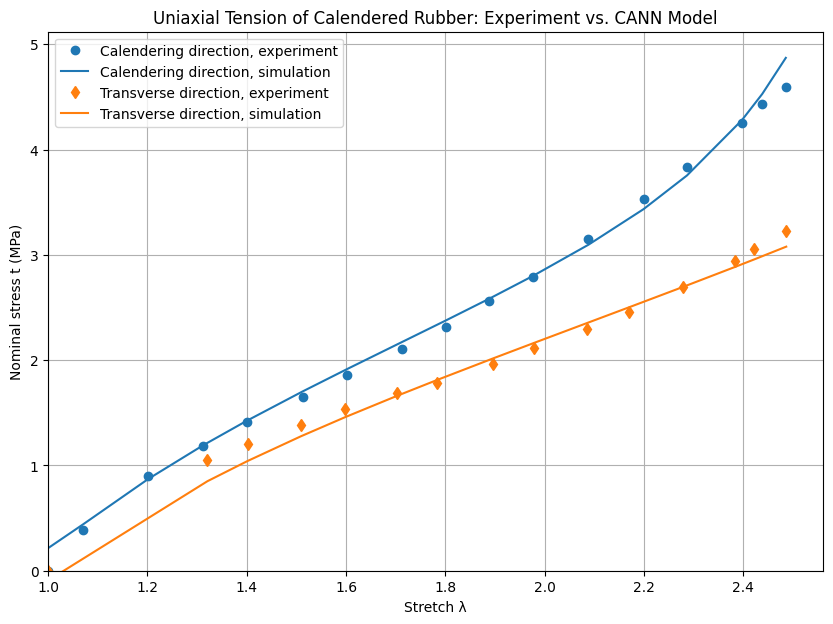

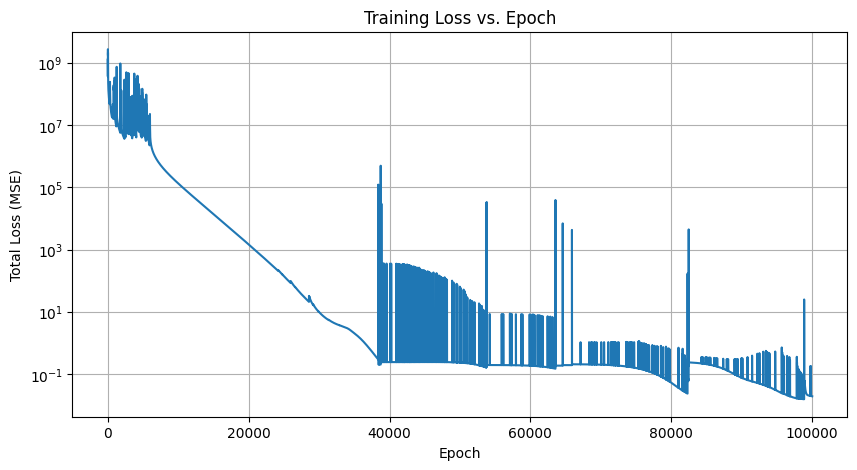


--- Final Identified Model Parameters ---
k1          : 1.217917
k2          : 1.879758
k3          : 1.322512
k4          : 1.808939
k5          : 1.313891
k6          : 1.802456
k7          : 1.323700
k8          : 1.807476
k9          : 1.085897
k10         : 1.025238
k11         : 1.464401
k12         : 1.442537
k13         : 1.454950
k14         : 1.306678
k15         : 1.413698
k16         : 1.476008
i1          : 1.075978
i2          : 1.105824
i3          : 1.299350
i4          : 1.250375
i5          : 1.281265
i6          : 1.263651
i7          : 1.290850
i8          : 1.249897
a1          : 0.004109
a2          : 0.132746
a3          : 0.013050
a4          : 0.013184
a5          : 0.009702
a6          : 0.010945
a7          : 0.010994
a8          : 0.022231
b1          : 0.091091
b2          : 0.000907
b3          : 0.007840
b4          : 0.014670
b5          : 0.004769
b6          : 0.012697
b7          : 0.024705
b8          : 0.014702
a3_prime    : 0.049747
a4_prime    : 

In [ ]:
# ==============================================================================
# SECTION 1: IMPORTS AND DATA PREPARATION
# ==============================================================================
# !pip install tensorflow numpy matplotlib pandas

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time

# --- Setup and Configuration ---
tf.keras.backend.set_floatx('float64')
DEVICE = "/GPU:0" if tf.config.list_physical_devices('GPU') else "/CPU:0"
print(f"Using device: {DEVICE}")

# Constants for numerical stability and clipping in the model
ARG_CLIP_MIN = tf.constant(-10.0, dtype=tf.float64)
ARG_CLIP_MAX = tf.constant(10.0, dtype=tf.float64)

# --- Provided Experimental Data ---
exp_data_raw_uniaxial_calendered = np.array([
    # [Stretch, Stress (MPa)]
    [1.0000, 0], [1.0708, 0.3840], [1.2017, 0.8987], [1.3125, 1.1814], [1.4000, 1.4093],
    [1.5125, 1.6456], [1.6017, 1.8608], [1.7125, 2.1055], [1.8008, 2.3122], [1.8883, 2.5570],
    [1.9767, 2.7848], [2.0883, 3.1519], [2.1992, 3.5274], [2.2867, 3.8354], [2.3975, 4.2532],
    [2.4383, 4.4304], [2.4858, 4.5949]
])

exp_data_raw_uniaxial_transverse = np.array([
    # [Stretch, Stress (MPa)]
    [1.0000, 0], [1.3208, 1.0506], [1.4017, 1.2068], [1.5092, 1.3840], [1.5983, 1.5401],
    [1.7017, 1.6835], [1.7842, 1.7848], [1.8967, 1.9662], [1.9792, 2.1181], [2.0858, 2.2911],
    [2.1708, 2.4599], [2.2783, 2.6962], [2.3825, 2.9409], [2.4225, 3.0549], [2.4867, 3.2236]
])

# Convert data to TensorFlow constants for efficiency
with tf.device(DEVICE):
    lambda_cal_exp = tf.constant(exp_data_raw_uniaxial_calendered[:, 0], dtype=tf.float64)
    stress_cal_exp = tf.constant(exp_data_raw_uniaxial_calendered[:, 1], dtype=tf.float64)

    lambda_tran_exp = tf.constant(exp_data_raw_uniaxial_transverse[:, 0], dtype=tf.float64)
    stress_tran_exp = tf.constant(exp_data_raw_uniaxial_transverse[:, 1], dtype=tf.float64)

# ==============================================================================
# SECTION 2: MODEL AND HELPER FUNCTION DEFINITIONS
# ==============================================================================

# --- Your Provided Constitutive ANN Model ---
class StrainEnergyANN_Layered_TF(tf.keras.Model):
    def __init__(self):
        super().__init__(name="StrainEnergyModel")
        # k & i params (exponents) - All parameters are now trainable
        self.raw_log_k1=self.add_weight(name="raw_log_k1",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_k2=self.add_weight(name="raw_log_k2",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_k3=self.add_weight(name="raw_log_k3",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_k4=self.add_weight(name="raw_log_k4",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_k5=self.add_weight(name="raw_log_k5",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_k6=self.add_weight(name="raw_log_k6",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_k7=self.add_weight(name="raw_log_k7",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_k8=self.add_weight(name="raw_log_k8",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_k9=self.add_weight(name="raw_log_k9",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_k10=self.add_weight(name="raw_log_k10",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_k11=self.add_weight(name="raw_log_k11",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_k12=self.add_weight(name="raw_log_k12",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_k13=self.add_weight(name="raw_log_k13",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_k14=self.add_weight(name="raw_log_k14",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_k15=self.add_weight(name="raw_log_k15",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_k16=self.add_weight(name="raw_log_k16",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_i1=self.add_weight(name="raw_log_i1",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_i2=self.add_weight(name="raw_log_i2",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_i3=self.add_weight(name="raw_log_i3",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_i4=self.add_weight(name="raw_log_i4",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_i5=self.add_weight(name="raw_log_i5",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_i6=self.add_weight(name="raw_log_i6",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_i7=self.add_weight(name="raw_log_i7",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_i8=self.add_weight(name="raw_log_i8",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        # Coefficients
        self.raw_log_a1=self.add_weight(name="raw_log_a1",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.1)),trainable=True)
        self.raw_log_a2=self.add_weight(name="raw_log_a2",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.1)),trainable=True)
        self.raw_log_a3=self.add_weight(name="raw_log_a3",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.1)),trainable=True)
        self.raw_log_a4=self.add_weight(name="raw_log_a4",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.1)),trainable=True)
        self.raw_log_a5=self.add_weight(name="raw_log_a5",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.1)),trainable=True)
        self.raw_log_a6=self.add_weight(name="raw_log_a6",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.1)),trainable=True)
        self.raw_log_a7=self.add_weight(name="raw_log_a7",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.1)),trainable=True)
        self.raw_log_a8=self.add_weight(name="raw_log_a8",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.1)),trainable=True)
        self.raw_log_b1=self.add_weight(name="raw_log_b1",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.01)),trainable=True)
        self.raw_log_b2=self.add_weight(name="raw_log_b2",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.01)),trainable=True)
        self.raw_log_b3=self.add_weight(name="raw_log_b3",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.1)),trainable=True)
        self.raw_log_b4=self.add_weight(name="raw_log_b4",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.1)),trainable=True)
        self.raw_log_b5=self.add_weight(name="raw_log_b5",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.1)),trainable=True)
        self.raw_log_b6=self.add_weight(name="raw_log_b6",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.1)),trainable=True)
        self.raw_log_b7=self.add_weight(name="raw_log_b7",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.1)),trainable=True)
        self.raw_log_b8=self.add_weight(name="raw_log_b8",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.1)),trainable=True)
        self.raw_log_a3_prime=self.add_weight(name="raw_log_a3_prime",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.2)),trainable=True)
        self.raw_log_a4_prime=self.add_weight(name="raw_log_a4_prime",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.2)),trainable=True)
        self.raw_log_a5_prime=self.add_weight(name="raw_log_a5_prime",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.2)),trainable=True)
        self.raw_log_a6_prime=self.add_weight(name="raw_log_a6_prime",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.2)),trainable=True)
        self.raw_log_a7_prime=self.add_weight(name="raw_log_a7_prime",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.2)),trainable=True)
        self.raw_log_a8_prime=self.add_weight(name="raw_log_a8_prime",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.2)),trainable=True)
        self.raw_log_b3_prime=self.add_weight(name="raw_log_b3_prime",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.2)),trainable=True)
        self.raw_log_b4_prime=self.add_weight(name="raw_log_b4_prime",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.2)),trainable=True)
        self.raw_log_b5_prime=self.add_weight(name="raw_log_b5_prime",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.2)),trainable=True)
        self.raw_log_b6_prime=self.add_weight(name="raw_log_b6_prime",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.2)),trainable=True)
        self.raw_log_b7_prime=self.add_weight(name="raw_log_b7_prime",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.2)),trainable=True)
        self.raw_log_b8_prime=self.add_weight(name="raw_log_b8_prime",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.2)),trainable=True)
        self.three=tf.constant(3.0,dtype=tf.float64); self.one=tf.constant(1.0,dtype=tf.float64); self.pow_base_epsilon=tf.constant(1e-8,dtype=tf.float64)
    def _term_power_law(self, I, k, i, c, ref_val): return c * tf.pow(tf.maximum(tf.pow(I, k) - tf.pow(ref_val, k), 0.0) + self.pow_base_epsilon, i)
    def _term_exponential(self, I, k, i, ic, oc, ref_val): return oc * (tf.exp(tf.clip_by_value(ic * tf.pow(tf.maximum(tf.pow(I, k) - tf.pow(ref_val, k), 0.0) + self.pow_base_epsilon, i), ARG_CLIP_MIN, ARG_CLIP_MAX)) - 1.0)
    def _term_cosh_minus_one_with_i(self, I, k, i, ic, oc, ref_val): return oc * (tf.cosh(tf.clip_by_value(ic * tf.pow(tf.maximum(tf.pow(I, k) - tf.pow(ref_val, k), 0.0) + self.pow_base_epsilon, i), ARG_CLIP_MIN, ARG_CLIP_MAX)) - 1.0)
    def _term_sinh_with_i(self, I, k, i, ic, oc, ref_val): return oc * tf.sinh(tf.clip_by_value(ic * tf.pow(tf.maximum(tf.pow(I, k) - tf.pow(ref_val, k), 0.0) + self.pow_base_epsilon, i), ARG_CLIP_MIN, ARG_CLIP_MAX))
    def _term_identity_scaled(self, I, k, c, ref_val): return c * (tf.pow(I, k) - tf.pow(ref_val, k))
    def _term_exponential_no_i(self, I, k, ic, oc, ref_val): return oc * (tf.exp(tf.clip_by_value(ic * (tf.pow(I, k) - tf.pow(ref_val, k)), ARG_CLIP_MIN, ARG_CLIP_MAX)) - 1.0)
    def _term_cosh_minus_one(self, I, k, ic, oc, ref_val): return oc * (tf.cosh(tf.clip_by_value(ic * (tf.pow(I, k) - tf.pow(ref_val, k)), ARG_CLIP_MIN, ARG_CLIP_MAX)) - 1.0)
    def _term_sinh(self, I, k, ic, oc, ref_val): return oc * tf.sinh(tf.clip_by_value(ic * (tf.pow(I, k) - tf.pow(ref_val, k)), ARG_CLIP_MIN, ARG_CLIP_MAX))
    def call(self, I1, I2, I4, I6):
        k1=1.0+tf.exp(self.raw_log_k1);k2=1.5+tf.exp(self.raw_log_k2);k3=1.0+tf.exp(self.raw_log_k3);k4=1.5+tf.exp(self.raw_log_k4);k5=1.0+tf.exp(self.raw_log_k5);k6=1.5+tf.exp(self.raw_log_k6);k7=1.0+tf.exp(self.raw_log_k7);k8=1.5+tf.exp(self.raw_log_k8);k9=1.0+tf.exp(self.raw_log_k9);k10=1.5+tf.exp(self.raw_log_k10);k11=1.0+tf.exp(self.raw_log_k11);k12=1.5+tf.exp(self.raw_log_k12);k13=1.0+tf.exp(self.raw_log_k13);k14=1.5+tf.exp(self.raw_log_k14);k15=1.0+tf.exp(self.raw_log_k15);k16=1.5+tf.exp(self.raw_log_k16)
        i1=1.0+tf.exp(self.raw_log_i1);i2=1.0+tf.exp(self.raw_log_i2);i3=1.0+tf.exp(self.raw_log_i3);i4=1.0+tf.exp(self.raw_log_i4);i5=1.0+tf.exp(self.raw_log_i5);i6=1.0+tf.exp(self.raw_log_i6);i7=1.0+tf.exp(self.raw_log_i7);i8=1.0+tf.exp(self.raw_log_i8)
        a1=tf.exp(self.raw_log_a1);a2=tf.exp(self.raw_log_a2);a3=tf.exp(self.raw_log_a3);a4=tf.exp(self.raw_log_a4);a5=tf.exp(self.raw_log_a5);a6=tf.exp(self.raw_log_a6);a7=tf.exp(self.raw_log_a7);a8=tf.exp(self.raw_log_a8)
        a3_prime=tf.exp(self.raw_log_a3_prime);a4_prime=tf.exp(self.raw_log_a4_prime);a5_prime=tf.exp(self.raw_log_a5_prime);a6_prime=tf.exp(self.raw_log_a6_prime);a7_prime=tf.exp(self.raw_log_a7_prime);a8_prime=tf.exp(self.raw_log_a8_prime)
        b1=tf.exp(self.raw_log_b1);b2=tf.exp(self.raw_log_b2);b3=tf.exp(self.raw_log_b3);b4=tf.exp(self.raw_log_b4);b5=tf.exp(self.raw_log_b5);b6=tf.exp(self.raw_log_b6);b7=tf.exp(self.raw_log_b7);b8=tf.exp(self.raw_log_b8)
        b3_prime=tf.exp(self.raw_log_b3_prime);b4_prime=tf.exp(self.raw_log_b4_prime);b5_prime=tf.exp(self.raw_log_b5_prime);b6_prime=tf.exp(self.raw_log_b6_prime);b7_prime=tf.exp(self.raw_log_b7_prime);b8_prime=tf.exp(self.raw_log_b8_prime)
        W = tf.zeros_like(I1,dtype=tf.float64)
        W += self._term_power_law(I1,k1,i1,a1,self.three); W += self._term_power_law(I2,k2,i2,a2,self.three)
        W += self._term_exponential(I1,k3,i3,a3_prime,a3,self.three); W += self._term_exponential(I2,k4,i4,a4_prime,a4,self.three)
        W += self._term_cosh_minus_one_with_i(I1,k5,i5,a5_prime,a5,self.three); W += self._term_cosh_minus_one_with_i(I2,k6,i6,a6_prime,a6,self.three)
        W += self._term_sinh_with_i(I1,k7,i7,a7_prime,a7,self.three); W += self._term_sinh_with_i(I2,k8,i8,a8_prime,a8,self.three)
        W += self._term_identity_scaled(I4,k9,b1,self.one); W += self._term_identity_scaled(I6,k10,b2,self.one)
        W += self._term_exponential_no_i(I4,k11,b3_prime,b3,self.one); W += self._term_exponential_no_i(I6,k12,b4_prime,b4,self.one)
        W += self._term_cosh_minus_one(I4,k13,b5_prime,b5,self.one); W += self._term_cosh_minus_one(I6,k14,b6_prime,b6,self.one)
        W += self._term_sinh(I4,k15,b7_prime,b7,self.one); W += self._term_sinh(I6,k16,b8_prime,b8,self.one)
        return W

# --- Helper Functions for Physics Calculations ---
@tf.function
def get_invariants_tf(lambda1, lambda2, lambda3):
    # Ensure all literals are float64 for consistency
    min_lambda_val = tf.constant(1e-4, dtype=tf.float64)
    two = tf.constant(2.0, dtype=tf.float64)

    lambda1 = tf.maximum(lambda1, min_lambda_val)
    lambda2 = tf.maximum(lambda2, min_lambda_val)
    lambda3 = tf.maximum(lambda3, min_lambda_val)

    l1s = tf.pow(lambda1, two); l2s = tf.pow(lambda2, two); l3s = tf.pow(lambda3, two)

    I1 = l1s + l2s + l3s
    I2 = tf.pow(lambda1 * lambda2, two) + tf.pow(lambda2 * lambda3, two) + tf.pow(lambda3 * lambda1, two)
    I4 = l1s
    I6 = l1s # Assuming I6 is also related to the fiber direction, similar to I4.
    return I1, I2, I4, I6

@tf.function
def get_W_and_gradients_tf(l1t, l2t, l3t, model):
    with tf.GradientTape(watch_accessed_variables=False, persistent=True) as tape:
        tape.watch([l1t, l2t, l3t])
        I1, I2, I4, I6 = get_invariants_tf(l1t, l2t, l3t)
        W_val = model(I1, I2, I4, I6)

    grads = tape.gradient(W_val, [l1t, l2t, l3t])
    dWdl1 = grads[0] if grads[0] is not None else tf.zeros_like(l1t)
    dWdl2 = grads[1] if grads[1] is not None else tf.zeros_like(l2t)
    dWdl3 = grads[2] if grads[2] is not None else tf.zeros_like(l3t)
    del tape
    return W_val, dWdl1, dWdl2, dWdl3

# ==============================================================================
# SECTION 3: PHYSICS-BASED STRESS CALCULATION FUNCTIONS (CORRECTED)
# ==============================================================================

@tf.function
def calculate_stress_calendering(lambda1_vals, model):
    """Calculates t1 for uniaxial tension in the calendering (fiber) direction."""
    lambda2_vals = tf.pow(lambda1_vals, tf.constant(-0.5, dtype=tf.float64))
    lambda3_vals = tf.pow(lambda1_vals, tf.constant(-0.5, dtype=tf.float64))
    _, dWdl1, _, dWdl3 = get_W_and_gradients_tf(lambda1_vals, lambda2_vals, lambda3_vals, model)
    t1_pred = dWdl1 - (lambda3_vals / lambda1_vals) * dWdl3
    return t1_pred

@tf.function
def calculate_stress_transverse(lambda2_exp, model):
    """Calculates t2 for uniaxial tension in the transverse direction."""
    one = tf.constant(1.0, dtype=tf.float64)

    def t1_objective(lambda1_guess, lambda2_val, model):
        lambda3_val = one / (lambda1_guess * lambda2_val)
        _, dWdl1, _, dWdl3 = get_W_and_gradients_tf(lambda1_guess, lambda2_val, lambda3_val, model)
        t1 = dWdl1 - (lambda3_val / lambda1_guess) * dWdl3
        return t1

    def find_lambda1_for_t1_zero(lambda2_val):
        lambda1_current = tf.ones_like(lambda2_val)

        for _ in tf.range(10): # Newton's method iterations
            with tf.GradientTape(watch_accessed_variables=False) as tape:
                tape.watch(lambda1_current)
                t1_val = t1_objective(lambda1_current, lambda2_val, model)

            dt1_dlambda1 = tape.gradient(t1_val, lambda1_current)

            # --- PRIMARY FIX: Ensure dtype consistency in tf.where ---
            # The original error was caused by mixing a float32 literal (1e-6)
            # with a float64 tensor (dt1_dlambda1).
            dt1_dlambda1 = tf.where(
                tf.abs(dt1_dlambda1) < 1e-6,
                tf.constant(1e-6, dtype=tf.float64),
                dt1_dlambda1
            )
            # -----------------------------------------------------------

            lambda1_next = lambda1_current - t1_val / dt1_dlambda1
            lambda1_current = lambda1_next
        return lambda1_current

    lambda1_eq = find_lambda1_for_t1_zero(lambda2_exp)
    lambda3_eq = one / (lambda1_eq * lambda2_exp)

    _, _, dWdl2, dWdl3 = get_W_and_gradients_tf(lambda1_eq, lambda2_exp, lambda3_eq, model)
    t2_pred = dWdl2 - (lambda3_eq / lambda2_exp) * dWdl3
    return t2_pred

# ==============================================================================
# SECTION 4: TRAINING LOOP
# ==============================================================================
# --- Training Setup ---
model = StrainEnergyANN_Layered_TF()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

# Loss is Mean Squared Error, equally weighted for both experiments
loss_fn = tf.keras.losses.MeanSquaredError()

@tf.function
def train_step():
    with tf.GradientTape() as tape:
        t1_pred = calculate_stress_calendering(lambda_cal_exp, model)
        t2_pred = calculate_stress_transverse(lambda_tran_exp, model)
        loss_cal = loss_fn(stress_cal_exp, t1_pred)
        loss_tran = loss_fn(stress_tran_exp, t2_pred)
        total_loss = loss_cal + loss_tran

    grads = tape.gradient(total_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    return total_loss, loss_cal, loss_tran

# --- Run the Training ---
epochs = 100000
history = []
print("Starting training...")
start_time = time.time()

for epoch in range(epochs):
    loss, loss_c, loss_t = train_step()
    history.append(loss.numpy())

    if (epoch + 1) % 500 == 0:
        print(f"Epoch {epoch+1:5d}/{epochs}, "
              f"Total Loss: {loss.numpy():.6f}, "
              f"(Cal Loss: {loss_c.numpy():.6f}, Tran Loss: {loss_t.numpy():.6f})")

end_time = time.time()
print(f"\nTraining finished in {end_time - start_time:.2f} seconds.")
print(f"Final Loss: {history[-1]:.6f}")

# ==============================================================================
# SECTION 5: VISUALIZATION AND RESULTS
# ==============================================================================

# Get final predictions from the trained model
with tf.device(DEVICE):
    t1_final_pred = calculate_stress_calendering(lambda_cal_exp, model)
    t2_final_pred = calculate_stress_transverse(lambda_tran_exp, model)

# Create a figure for the results
plt.figure(figsize=(10, 7))
plt.plot(exp_data_raw_uniaxial_calendered[:, 0], exp_data_raw_uniaxial_calendered[:, 1], 'o', label='Calendering direction, experiment')
plt.plot(lambda_cal_exp.numpy(), t1_final_pred.numpy(), '-', color='C0', label='Calendering direction, simulation')

plt.plot(exp_data_raw_uniaxial_transverse[:, 0], exp_data_raw_uniaxial_transverse[:, 1], 'd', label='Transverse direction, experiment')
plt.plot(lambda_tran_exp.numpy(), t2_final_pred.numpy(), '-', color='C1', label='Transverse direction, simulation')

plt.title('Uniaxial Tension of Calendered Rubber: Experiment vs. CANN Model')
plt.xlabel('Stretch λ')
plt.ylabel('Nominal stress t (MPa)')
plt.legend()
plt.grid(True)
plt.xlim(left=1.0)
plt.ylim(bottom=0.0)
plt.show()

# Plot the training loss
plt.figure(figsize=(10, 5))
plt.plot(history)
plt.title('Training Loss vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('Total Loss (MSE)')
plt.yscale('log')
plt.grid(True)
plt.show()

# For your paper, you should also list the final identified parameters
print("\n--- Final Identified Model Parameters ---")
for var in model.trainable_variables:
    if 'raw_log' in var.name:
      param_name = var.name.replace('raw_log_', '').replace(':0', '')
      # Handle offsets used during parameter definition
      if param_name.startswith('k'):
          offset = 1.0 if any(s in param_name for s in ['k1', 'k3', 'k5', 'k7', 'k9', 'k11', 'k13', 'k15']) else 1.5
          value = offset + np.exp(var.numpy())
      elif param_name.startswith('i'):
          offset = 1.0
          value = offset + np.exp(var.numpy())
      else:
          value = np.exp(var.numpy())
      print(f"{param_name:<12s}: {value:.6f}")

Using device: /CPU:0
Starting improved training...
Epoch  1000/30000, Total Norm Loss: 201657.863180, (Cal MSE: 398910.601180, Tran MSE: 680221.702316)
Epoch  2000/30000, Total Norm Loss: 63104.962511, (Cal MSE: 120685.248508, Tran MSE: 215316.721890)
Epoch  3000/30000, Total Norm Loss: 31776.441488, (Cal MSE: 60055.238114, Tran MSE: 108846.189461)
Epoch  4000/30000, Total Norm Loss: 17896.643698, (Cal MSE: 33585.544124, Tran MSE: 61443.494015)
Epoch  5000/30000, Total Norm Loss: 11102.786540, (Cal MSE: 20739.610013, Tran MSE: 38175.558769)
Epoch  6000/30000, Total Norm Loss: 6976.123190, (Cal MSE: 12980.183876, Tran MSE: 24016.706947)
Epoch  7000/30000, Total Norm Loss: 4582.194810, (Cal MSE: 8497.232623, Tran MSE: 15792.097302)
Epoch  8000/30000, Total Norm Loss: 2981.075040, (Cal MSE: 5508.476022, Tran MSE: 10285.614761)
Epoch  9000/30000, Total Norm Loss: 1996.312222, (Cal MSE: 3675.327921, Tran MSE: 6895.868369)
Epoch 10000/30000, Total Norm Loss: 1314.051659, (Cal MSE: 2408.56194

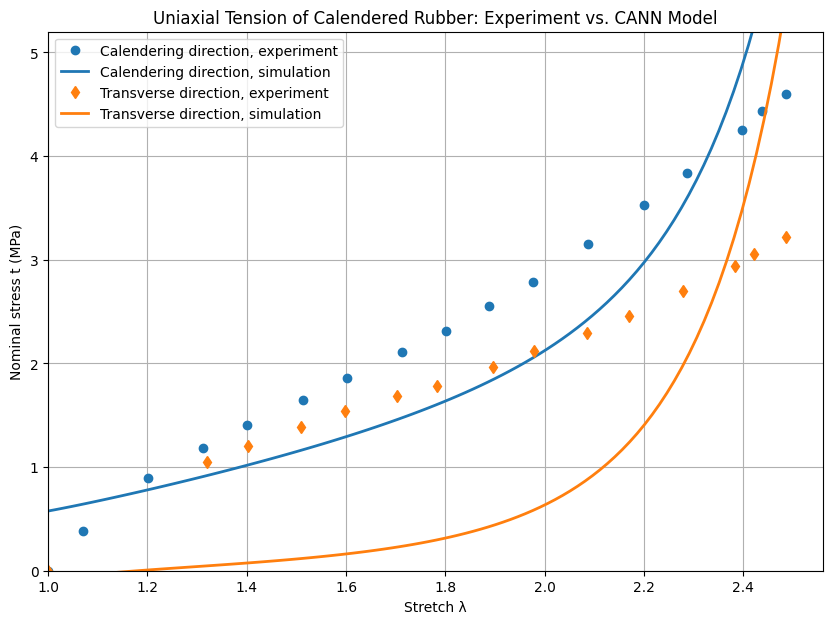

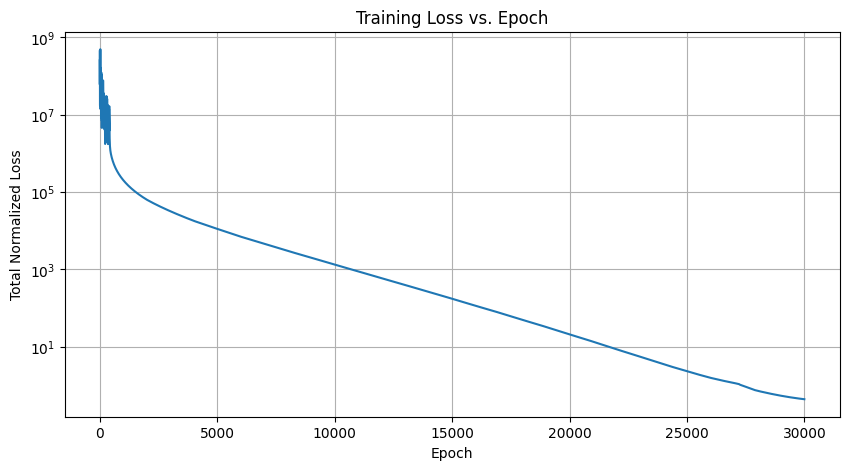


--- Final Identified Model Parameters ---
k1          : 1.183639
k2          : 1.705549
k3          : 1.472128
k4          : 1.947711
k5          : 1.452238
k6          : 1.943633
k7          : 1.465625
k8          : 1.927056
k9          : 1.245532
k10         : 1.084516
k11         : 1.423352
k12         : 1.434799
k13         : 1.413256
k14         : 1.438644
k15         : 1.432251
k16         : 1.438242
i1          : 1.176001
i2          : 1.171251
i3          : 1.419806
i4          : 1.378725
i5          : 1.401571
i6          : 1.378432
i7          : 1.411247
i8          : 1.366306
a1          : 0.001049
a2          : 0.001448
a3          : 0.021569
a4          : 0.019779
a5          : 0.019115
a6          : 0.018911
a7          : 0.020491
a8          : 0.016875
b1          : 0.230494
b2          : 0.000010
b3          : 0.004746
b4          : 0.015214
b5          : 0.004147
b6          : 0.015229
b7          : 0.005566
b8          : 0.015466
a3_prime    : 0.069752
a4_prime    : 

In [ ]:
# ==============================================================================
# SECTION 1: IMPORTS AND DATA PREPARATION
# ==============================================================================
# !pip install tensorflow numpy matplotlib pandas

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time

# --- Setup and Configuration ---
tf.keras.backend.set_floatx('float64')
DEVICE = "/GPU:0" if tf.config.list_physical_devices('GPU') else "/CPU:0"
print(f"Using device: {DEVICE}")

# Constants for numerical stability and clipping in the model
ARG_CLIP_MIN = tf.constant(-10.0, dtype=tf.float64)
ARG_CLIP_MAX = tf.constant(10.0, dtype=tf.float64)

# --- Provided Experimental Data ---
exp_data_raw_uniaxial_calendered = np.array([
    # [Stretch, Stress (MPa)]
    [1.0000, 0], [1.0708, 0.3840], [1.2017, 0.8987], [1.3125, 1.1814], [1.4000, 1.4093],
    [1.5125, 1.6456], [1.6017, 1.8608], [1.7125, 2.1055], [1.8008, 2.3122], [1.8883, 2.5570],
    [1.9767, 2.7848], [2.0883, 3.1519], [2.1992, 3.5274], [2.2867, 3.8354], [2.3975, 4.2532],
    [2.4383, 4.4304], [2.4858, 4.5949]
])

exp_data_raw_uniaxial_transverse = np.array([
    # [Stretch, Stress (MPa)]
    [1.0000, 0], [1.3208, 1.0506], [1.4017, 1.2068], [1.5092, 1.3840], [1.5983, 1.5401],
    [1.7017, 1.6835], [1.7842, 1.7848], [1.8967, 1.9662], [1.9792, 2.1181], [2.0858, 2.2911],
    [2.1708, 2.4599], [2.2783, 2.6962], [2.3825, 2.9409], [2.4225, 3.0549], [2.4867, 3.2236]
])

# Convert data to TensorFlow constants for efficiency
with tf.device(DEVICE):
    lambda_cal_exp = tf.constant(exp_data_raw_uniaxial_calendered[:, 0], dtype=tf.float64)
    stress_cal_exp = tf.constant(exp_data_raw_uniaxial_calendered[:, 1], dtype=tf.float64)

    lambda_tran_exp = tf.constant(exp_data_raw_uniaxial_transverse[:, 0], dtype=tf.float64)
    stress_tran_exp = tf.constant(exp_data_raw_uniaxial_transverse[:, 1], dtype=tf.float64)

# ==============================================================================
# SECTION 2: MODEL AND HELPER FUNCTION DEFINITIONS
# ==============================================================================

# --- Your Provided Constitutive ANN Model ---
# NOTE: The model architecture is kept the same as in the original problem.
class StrainEnergyANN_Layered_TF(tf.keras.Model):
    def __init__(self):
        super().__init__(name="StrainEnergyModel")
        # k & i params (exponents) - All parameters are now trainable
        self.raw_log_k1=self.add_weight(name="raw_log_k1",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_k2=self.add_weight(name="raw_log_k2",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_k3=self.add_weight(name="raw_log_k3",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_k4=self.add_weight(name="raw_log_k4",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_k5=self.add_weight(name="raw_log_k5",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_k6=self.add_weight(name="raw_log_k6",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_k7=self.add_weight(name="raw_log_k7",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_k8=self.add_weight(name="raw_log_k8",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_k9=self.add_weight(name="raw_log_k9",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_k10=self.add_weight(name="raw_log_k10",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_k11=self.add_weight(name="raw_log_k11",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_k12=self.add_weight(name="raw_log_k12",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_k13=self.add_weight(name="raw_log_k13",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_k14=self.add_weight(name="raw_log_k14",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_k15=self.add_weight(name="raw_log_k15",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_k16=self.add_weight(name="raw_log_k16",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_i1=self.add_weight(name="raw_log_i1",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_i2=self.add_weight(name="raw_log_i2",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_i3=self.add_weight(name="raw_log_i3",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_i4=self.add_weight(name="raw_log_i4",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_i5=self.add_weight(name="raw_log_i5",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_i6=self.add_weight(name="raw_log_i6",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_i7=self.add_weight(name="raw_log_i7",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_i8=self.add_weight(name="raw_log_i8",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        # Coefficients
        self.raw_log_a1=self.add_weight(name="raw_log_a1",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.1)),trainable=True)
        self.raw_log_a2=self.add_weight(name="raw_log_a2",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.1)),trainable=True)
        self.raw_log_a3=self.add_weight(name="raw_log_a3",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.1)),trainable=True)
        self.raw_log_a4=self.add_weight(name="raw_log_a4",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.1)),trainable=True)
        self.raw_log_a5=self.add_weight(name="raw_log_a5",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.1)),trainable=True)
        self.raw_log_a6=self.add_weight(name="raw_log_a6",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.1)),trainable=True)
        self.raw_log_a7=self.add_weight(name="raw_log_a7",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.1)),trainable=True)
        self.raw_log_a8=self.add_weight(name="raw_log_a8",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.1)),trainable=True)
        self.raw_log_b1=self.add_weight(name="raw_log_b1",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.01)),trainable=True)
        self.raw_log_b2=self.add_weight(name="raw_log_b2",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.01)),trainable=True)
        self.raw_log_b3=self.add_weight(name="raw_log_b3",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.1)),trainable=True)
        self.raw_log_b4=self.add_weight(name="raw_log_b4",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.1)),trainable=True)
        self.raw_log_b5=self.add_weight(name="raw_log_b5",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.1)),trainable=True)
        self.raw_log_b6=self.add_weight(name="raw_log_b6",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.1)),trainable=True)
        self.raw_log_b7=self.add_weight(name="raw_log_b7",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.1)),trainable=True)
        self.raw_log_b8=self.add_weight(name="raw_log_b8",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.1)),trainable=True)
        self.raw_log_a3_prime=self.add_weight(name="raw_log_a3_prime",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.2)),trainable=True)
        self.raw_log_a4_prime=self.add_weight(name="raw_log_a4_prime",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.2)),trainable=True)
        self.raw_log_a5_prime=self.add_weight(name="raw_log_a5_prime",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.2)),trainable=True)
        self.raw_log_a6_prime=self.add_weight(name="raw_log_a6_prime",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.2)),trainable=True)
        self.raw_log_a7_prime=self.add_weight(name="raw_log_a7_prime",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.2)),trainable=True)
        self.raw_log_a8_prime=self.add_weight(name="raw_log_a8_prime",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.2)),trainable=True)
        self.raw_log_b3_prime=self.add_weight(name="raw_log_b3_prime",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.2)),trainable=True)
        self.raw_log_b4_prime=self.add_weight(name="raw_log_b4_prime",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.2)),trainable=True)
        self.raw_log_b5_prime=self.add_weight(name="raw_log_b5_prime",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.2)),trainable=True)
        self.raw_log_b6_prime=self.add_weight(name="raw_log_b6_prime",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.2)),trainable=True)
        self.raw_log_b7_prime=self.add_weight(name="raw_log_b7_prime",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.2)),trainable=True)
        self.raw_log_b8_prime=self.add_weight(name="raw_log_b8_prime",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.2)),trainable=True)
        self.three=tf.constant(3.0,dtype=tf.float64); self.one=tf.constant(1.0,dtype=tf.float64); self.pow_base_epsilon=tf.constant(1e-8,dtype=tf.float64)
    def _term_power_law(self, I, k, i, c, ref_val): return c * tf.pow(tf.maximum(tf.pow(I, k) - tf.pow(ref_val, k), 0.0) + self.pow_base_epsilon, i)
    def _term_exponential(self, I, k, i, ic, oc, ref_val): return oc * (tf.exp(tf.clip_by_value(ic * tf.pow(tf.maximum(tf.pow(I, k) - tf.pow(ref_val, k), 0.0) + self.pow_base_epsilon, i), ARG_CLIP_MIN, ARG_CLIP_MAX)) - 1.0)
    def _term_cosh_minus_one_with_i(self, I, k, i, ic, oc, ref_val): return oc * (tf.cosh(tf.clip_by_value(ic * tf.pow(tf.maximum(tf.pow(I, k) - tf.pow(ref_val, k), 0.0) + self.pow_base_epsilon, i), ARG_CLIP_MIN, ARG_CLIP_MAX)) - 1.0)
    def _term_sinh_with_i(self, I, k, i, ic, oc, ref_val): return oc * tf.sinh(tf.clip_by_value(ic * tf.pow(tf.maximum(tf.pow(I, k) - tf.pow(ref_val, k), 0.0) + self.pow_base_epsilon, i), ARG_CLIP_MIN, ARG_CLIP_MAX))
    def _term_identity_scaled(self, I, k, c, ref_val): return c * (tf.pow(I, k) - tf.pow(ref_val, k))
    def _term_exponential_no_i(self, I, k, ic, oc, ref_val): return oc * (tf.exp(tf.clip_by_value(ic * (tf.pow(I, k) - tf.pow(ref_val, k)), ARG_CLIP_MIN, ARG_CLIP_MAX)) - 1.0)
    def _term_cosh_minus_one(self, I, k, ic, oc, ref_val): return oc * (tf.cosh(tf.clip_by_value(ic * (tf.pow(I, k) - tf.pow(ref_val, k)), ARG_CLIP_MIN, ARG_CLIP_MAX)) - 1.0)
    def _term_sinh(self, I, k, ic, oc, ref_val): return oc * tf.sinh(tf.clip_by_value(ic * (tf.pow(I, k) - tf.pow(ref_val, k)), ARG_CLIP_MIN, ARG_CLIP_MAX))
    def call(self, I1, I2, I4, I6):
        k1=1.0+tf.exp(self.raw_log_k1);k2=1.5+tf.exp(self.raw_log_k2);k3=1.0+tf.exp(self.raw_log_k3);k4=1.5+tf.exp(self.raw_log_k4);k5=1.0+tf.exp(self.raw_log_k5);k6=1.5+tf.exp(self.raw_log_k6);k7=1.0+tf.exp(self.raw_log_k7);k8=1.5+tf.exp(self.raw_log_k8);k9=1.0+tf.exp(self.raw_log_k9);k10=1.5+tf.exp(self.raw_log_k10);k11=1.0+tf.exp(self.raw_log_k11);k12=1.5+tf.exp(self.raw_log_k12);k13=1.0+tf.exp(self.raw_log_k13);k14=1.5+tf.exp(self.raw_log_k14);k15=1.0+tf.exp(self.raw_log_k15);k16=1.5+tf.exp(self.raw_log_k16)
        i1=1.0+tf.exp(self.raw_log_i1);i2=1.0+tf.exp(self.raw_log_i2);i3=1.0+tf.exp(self.raw_log_i3);i4=1.0+tf.exp(self.raw_log_i4);i5=1.0+tf.exp(self.raw_log_i5);i6=1.0+tf.exp(self.raw_log_i6);i7=1.0+tf.exp(self.raw_log_i7);i8=1.0+tf.exp(self.raw_log_i8)
        a1=tf.exp(self.raw_log_a1);a2=tf.exp(self.raw_log_a2);a3=tf.exp(self.raw_log_a3);a4=tf.exp(self.raw_log_a4);a5=tf.exp(self.raw_log_a5);a6=tf.exp(self.raw_log_a6);a7=tf.exp(self.raw_log_a7);a8=tf.exp(self.raw_log_a8)
        a3_prime=tf.exp(self.raw_log_a3_prime);a4_prime=tf.exp(self.raw_log_a4_prime);a5_prime=tf.exp(self.raw_log_a5_prime);a6_prime=tf.exp(self.raw_log_a6_prime);a7_prime=tf.exp(self.raw_log_a7_prime);a8_prime=tf.exp(self.raw_log_a8_prime)
        b1=tf.exp(self.raw_log_b1);b2=tf.exp(self.raw_log_b2);b3=tf.exp(self.raw_log_b3);b4=tf.exp(self.raw_log_b4);b5=tf.exp(self.raw_log_b5);b6=tf.exp(self.raw_log_b6);b7=tf.exp(self.raw_log_b7);b8=tf.exp(self.raw_log_b8)
        b3_prime=tf.exp(self.raw_log_b3_prime);b4_prime=tf.exp(self.raw_log_b4_prime);b5_prime=tf.exp(self.raw_log_b5_prime);b6_prime=tf.exp(self.raw_log_b6_prime);b7_prime=tf.exp(self.raw_log_b7_prime);b8_prime=tf.exp(self.raw_log_b8_prime)
        W = tf.zeros_like(I1,dtype=tf.float64)
        W += self._term_power_law(I1,k1,i1,a1,self.three); W += self._term_power_law(I2,k2,i2,a2,self.three)
        W += self._term_exponential(I1,k3,i3,a3_prime,a3,self.three); W += self._term_exponential(I2,k4,i4,a4_prime,a4,self.three)
        W += self._term_cosh_minus_one_with_i(I1,k5,i5,a5_prime,a5,self.three); W += self._term_cosh_minus_one_with_i(I2,k6,i6,a6_prime,a6,self.three)
        W += self._term_sinh_with_i(I1,k7,i7,a7_prime,a7,self.three); W += self._term_sinh_with_i(I2,k8,i8,a8_prime,a8,self.three)
        W += self._term_identity_scaled(I4,k9,b1,self.one); W += self._term_identity_scaled(I6,k10,b2,self.one)
        W += self._term_exponential_no_i(I4,k11,b3_prime,b3,self.one); W += self._term_exponential_no_i(I6,k12,b4_prime,b4,self.one)
        W += self._term_cosh_minus_one(I4,k13,b5_prime,b5,self.one); W += self._term_cosh_minus_one(I6,k14,b6_prime,b6,self.one)
        W += self._term_sinh(I4,k15,b7_prime,b7,self.one); W += self._term_sinh(I6,k16,b8_prime,b8,self.one)
        return W

# --- Helper Functions for Physics Calculations ---
@tf.function
def get_invariants_tf(lambda1, lambda2, lambda3):
    min_lambda_val = tf.constant(1e-4, dtype=tf.float64)
    two = tf.constant(2.0, dtype=tf.float64)
    lambda1 = tf.maximum(lambda1, min_lambda_val); lambda2 = tf.maximum(lambda2, min_lambda_val); lambda3 = tf.maximum(lambda3, min_lambda_val)
    l1s = tf.pow(lambda1, two); l2s = tf.pow(lambda2, two); l3s = tf.pow(lambda3, two)
    I1 = l1s + l2s + l3s
    I2 = tf.pow(lambda1 * lambda2, two) + tf.pow(lambda2 * lambda3, two) + tf.pow(lambda3 * lambda1, two)
    I4 = l1s
    I6 = l2s # I6 is associated with the transverse direction (2)
    return I1, I2, I4, I6

@tf.function
def get_W_and_gradients_tf(l1t, l2t, l3t, model):
    with tf.GradientTape(watch_accessed_variables=False, persistent=True) as tape:
        tape.watch([l1t, l2t, l3t])
        I1, I2, I4, I6 = get_invariants_tf(l1t, l2t, l3t)
        W_val = model(I1, I2, I4, I6)
    grads = tape.gradient(W_val, [l1t, l2t, l3t])
    dWdl1 = grads[0] if grads[0] is not None else tf.zeros_like(l1t)
    dWdl2 = grads[1] if grads[1] is not None else tf.zeros_like(l2t)
    dWdl3 = grads[2] if grads[2] is not None else tf.zeros_like(l3t)
    del tape
    return W_val, dWdl1, dWdl2, dWdl3

# ==============================================================================
# SECTION 3: PHYSICS-BASED STRESS CALCULATION FUNCTIONS (CORRECTED & IMPROVED)
# ==============================================================================

@tf.function
def calculate_stress_calendering(lambda1_vals, model):
    lambda2_vals = tf.pow(lambda1_vals, tf.constant(-0.5, dtype=tf.float64))
    lambda3_vals = tf.pow(lambda1_vals, tf.constant(-0.5, dtype=tf.float64))
    _, dWdl1, _, dWdl3 = get_W_and_gradients_tf(lambda1_vals, lambda2_vals, lambda3_vals, model)
    t1_pred = dWdl1 - (lambda3_vals / lambda1_vals) * dWdl3
    return t1_pred

@tf.function
def calculate_stress_transverse(lambda2_exp, model):
    one = tf.constant(1.0, dtype=tf.float64)

    def t1_objective(lambda1_guess, lambda2_val, model):
        lambda3_val = one / (lambda1_guess * lambda2_val)
        _, dWdl1, _, dWdl3 = get_W_and_gradients_tf(lambda1_guess, lambda2_val, lambda3_val, model)
        t1 = dWdl1 - (lambda3_val / lambda1_guess) * dWdl3
        return t1

    def find_lambda1_for_t1_zero(lambda2_val):
        # **FIX 1:** Ensure exponent is float64
        lambda1_current = tf.pow(lambda2_val, tf.constant(-0.5, dtype=tf.float64))

        for _ in tf.range(20):
            with tf.GradientTape(watch_accessed_variables=False) as tape:
                tape.watch(lambda1_current)
                t1_val = t1_objective(lambda1_current, lambda2_val, model)
            dt1_dlambda1 = tape.gradient(t1_val, lambda1_current)
            dt1_dlambda1 = tf.where(tf.abs(dt1_dlambda1) < 1e-6, tf.constant(1e-6, dtype=tf.float64), dt1_dlambda1)
            lambda1_next = lambda1_current - t1_val / dt1_dlambda1
            # **FIX 2:** Ensure minimum value literal is float64
            lambda1_current = tf.maximum(tf.constant(1e-4, dtype=tf.float64), lambda1_next)
        return lambda1_current

    lambda1_eq = find_lambda1_for_t1_zero(lambda2_exp)
    lambda3_eq = one / (lambda1_eq * lambda2_exp)
    _, _, dWdl2, dWdl3 = get_W_and_gradients_tf(lambda1_eq, lambda2_exp, lambda3_eq, model)
    t2_pred = dWdl2 - (lambda3_eq / lambda2_exp) * dWdl3
    return t2_pred

# ==============================================================================
# SECTION 4: TRAINING LOOP (IMPROVED)
# ==============================================================================
# --- Training Setup ---
model = StrainEnergyANN_Layered_TF()

initial_learning_rate = 0.01
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=2000,
    decay_rate=0.9,
    staircase=True)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

loss_fn = tf.keras.losses.MeanSquaredError()

norm_cal = tf.reduce_mean(tf.square(stress_cal_exp))
norm_tran = tf.reduce_mean(tf.square(stress_tran_exp))

@tf.function
def train_step():
    with tf.GradientTape() as tape:
        t1_pred = calculate_stress_calendering(lambda_cal_exp, model)
        t2_pred = calculate_stress_transverse(lambda_tran_exp, model)

        loss_cal = loss_fn(stress_cal_exp, t1_pred) / norm_cal
        loss_tran = loss_fn(stress_tran_exp, t2_pred) / norm_tran

        total_loss = loss_cal + loss_tran

    grads = tape.gradient(total_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    return total_loss, loss_fn(stress_cal_exp, t1_pred), loss_fn(stress_tran_exp, t2_pred)

# --- Run the Training ---
epochs = 30000
history = []
print("Starting improved training...")
start_time = time.time()

for epoch in range(epochs):
    loss, loss_c, loss_t = train_step()
    history.append(loss.numpy())

    if (epoch + 1) % 1000 == 0:
        print(f"Epoch {epoch+1:5d}/{epochs}, "
              f"Total Norm Loss: {loss.numpy():.6f}, "
              f"(Cal MSE: {loss_c.numpy():.6f}, Tran MSE: {loss_t.numpy():.6f})")

end_time = time.time()
print(f"\nTraining finished in {end_time - start_time:.2f} seconds.")
print(f"Final Normalized Loss: {history[-1]:.6f}")

# ==============================================================================
# SECTION 5: VISUALIZATION AND RESULTS
# ==============================================================================

# Get final predictions from the trained model
with tf.device(DEVICE):
    lambda_cal_sim = tf.linspace(tf.reduce_min(lambda_cal_exp), tf.reduce_max(lambda_cal_exp), 100)
    lambda_tran_sim = tf.linspace(tf.reduce_min(lambda_tran_exp), tf.reduce_max(lambda_tran_exp), 100)
    t1_final_pred = calculate_stress_calendering(lambda_cal_sim, model)
    t2_final_pred = calculate_stress_transverse(lambda_tran_sim, model)

# Create a figure for the results
plt.figure(figsize=(10, 7))
plt.plot(exp_data_raw_uniaxial_calendered[:, 0], exp_data_raw_uniaxial_calendered[:, 1], 'o', color='C0', label='Calendering direction, experiment')
plt.plot(lambda_cal_sim.numpy(), t1_final_pred.numpy(), '-', color='C0', linewidth=2, label='Calendering direction, simulation')

plt.plot(exp_data_raw_uniaxial_transverse[:, 0], exp_data_raw_uniaxial_transverse[:, 1], 'd', color='C1', label='Transverse direction, experiment')
plt.plot(lambda_tran_sim.numpy(), t2_final_pred.numpy(), '-', color='C1', linewidth=2, label='Transverse direction, simulation')

plt.title('Uniaxial Tension of Calendered Rubber: Experiment vs. CANN Model')
plt.xlabel('Stretch λ')
plt.ylabel('Nominal stress t (MPa)')
plt.legend()
plt.grid(True)
plt.xlim(left=1.0)
plt.ylim(bottom=0.0, top=5.2)
plt.show()

# Plot the training loss
plt.figure(figsize=(10, 5))
plt.plot(history)
plt.title('Training Loss vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('Total Normalized Loss')
plt.yscale('log')
plt.grid(True)
plt.show()

# For your paper, you should also list the final identified parameters
print("\n--- Final Identified Model Parameters ---")
for var in model.trainable_variables:
    if 'raw_log' in var.name:
      param_name = var.name.replace('raw_log_', '').replace(':0', '')
      # Handle offsets used during parameter definition
      if param_name.startswith('k'):
          offset = 1.0 if any(s in param_name for s in ['k1', 'k3', 'k5', 'k7', 'k9', 'k11', 'k13', 'k15']) else 1.5
          value = offset + np.exp(var.numpy())
      elif param_name.startswith('i'):
          offset = 1.0
          value = offset + np.exp(var.numpy())
      else:
          value = np.exp(var.numpy())
      print(f"{param_name:<12s}: {value:.6f}")

Using device: /CPU:0
Biaxial Loss Weight: 1.69
Epoch     0, Loss: 2217839782.9653 (Uni: 998647859.3373, Bi: 721715500.4352), LR: 0.010000
Epoch  1000, Loss: 0.0849 (Uni: 0.0557, Bi: 0.0173), LR: 0.010000
Epoch  2000, Loss: 0.0180 (Uni: 0.0061, Bi: 0.0071), LR: 0.009000
Epoch  3000, Loss: 0.0141 (Uni: 0.0034, Bi: 0.0064), LR: 0.009000
Epoch  4000, Loss: 0.0127 (Uni: 0.0026, Bi: 0.0060), LR: 0.008100
Epoch  5000, Loss: 0.0111 (Uni: 0.0021, Bi: 0.0053), LR: 0.008100
Epoch  6000, Loss: 0.0067 (Uni: 0.0012, Bi: 0.0033), LR: 0.007290
Epoch  7000, Loss: 0.0043 (Uni: 0.0008, Bi: 0.0021), LR: 0.007290
Epoch  8000, Loss: 0.0034 (Uni: 0.0006, Bi: 0.0016), LR: 0.006561
Epoch  9000, Loss: 0.0030 (Uni: 0.0006, Bi: 0.0014), LR: 0.006561
Epoch 10000, Loss: 0.0028 (Uni: 0.0006, Bi: 0.0013), LR: 0.005905
Epoch 11000, Loss: 0.0027 (Uni: 0.0006, Bi: 0.0012), LR: 0.005905
Epoch 12000, Loss: 0.0025 (Uni: 0.0005, Bi: 0.0012), LR: 0.005314
Epoch 13000, Loss: 0.0022 (Uni: 0.0003, Bi: 0.0012), LR: 0.005314
Epoc

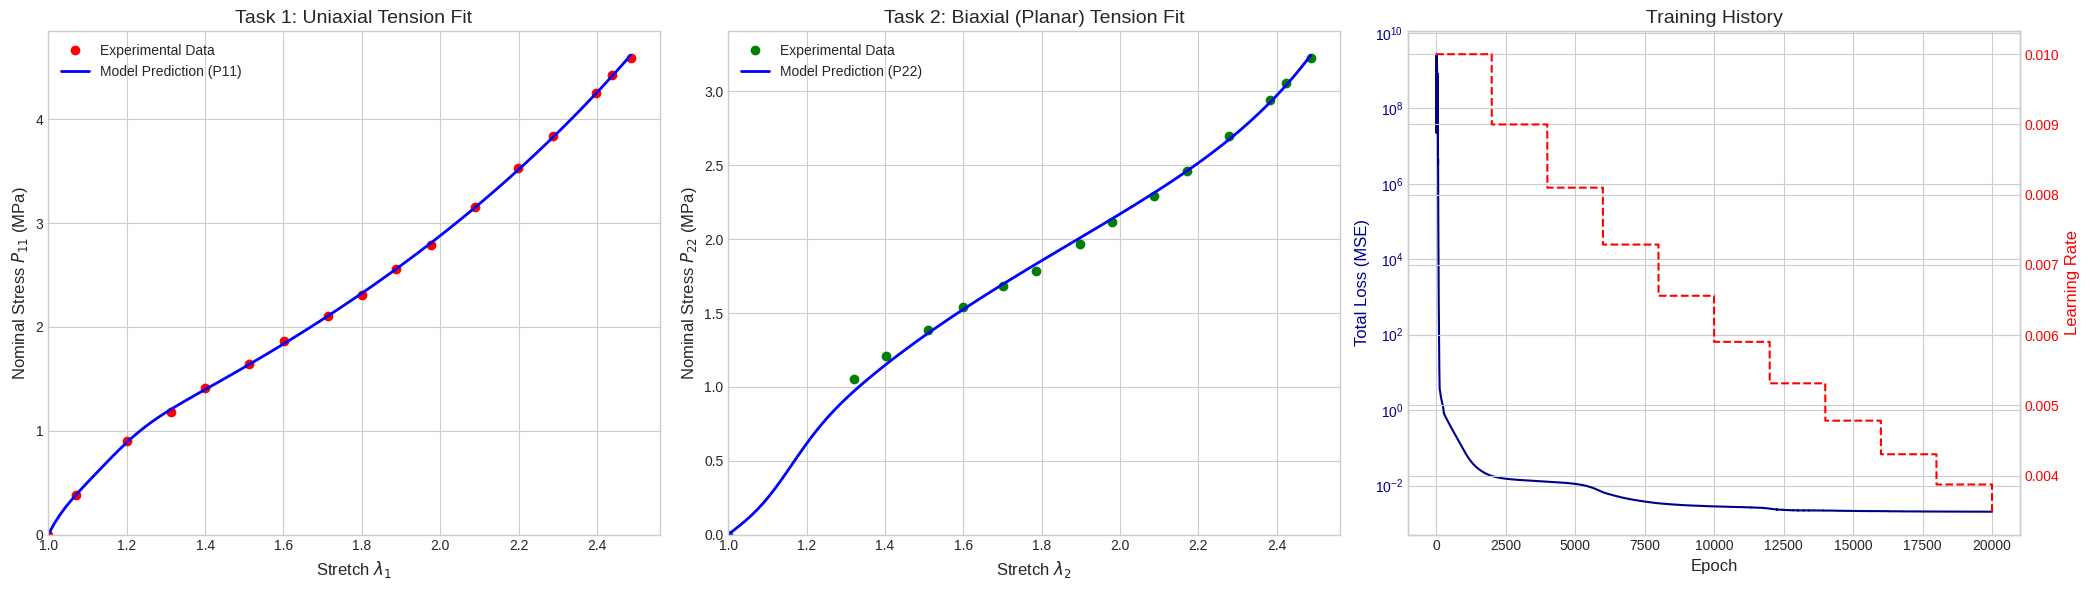

In [ ]:
#With Bisection method for root finding and using smooth_relu instead of tf.max in the case of exponential activations.

!pip install tensorflow -q

import tensorflow as tf
import numpy as np
from io import StringIO
import pandas as pd
import matplotlib.pyplot as plt

# --- Setup and Constants ---

tf.keras.backend.set_floatx('float64')
DEVICE = "/GPU:0" if tf.config.list_physical_devices('GPU') else "/CPU:0"
print(f"Using device: {DEVICE}")

ARG_CLIP_MIN = tf.constant(-10.0, dtype=tf.float64)
ARG_CLIP_MAX = tf.constant(10.0, dtype=tf.float64)

# --- FIX 1: ADD A SMOOTH RELU (SOFTPLUS) FUNCTION ---
# This function is a smooth, differentiable approximation of tf.maximum(x, 0.0).
# Using this instead of tf.maximum will prevent sharp edges in the gradient-derived stress predictions.
# The 'beta' parameter controls the "sharpness" of the transition.
@tf.function
def smooth_relu(x, beta=20.0):
    return tf.nn.softplus(beta * x) / beta

# --- Model Definition (With Fixes) ---

class StrainEnergyANN_Layered_TF(tf.keras.Model):
    # --- FIX 2: CORRECTED CONSTRUCTOR NAME (init -> __init__) ---
    def __init__(self):
        super().__init__(name="StrainEnergyModel")
        # k & i params (exponents) - All parameters are now trainable
        self.raw_log_k1=self.add_weight(name="raw_log_k1",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_k2=self.add_weight(name="raw_log_k2",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_k3=self.add_weight(name="raw_log_k3",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_k4=self.add_weight(name="raw_log_k4",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_k5=self.add_weight(name="raw_log_k5",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_k6=self.add_weight(name="raw_log_k6",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_k7=self.add_weight(name="raw_log_k7",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_k8=self.add_weight(name="raw_log_k8",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_k9=self.add_weight(name="raw_log_k9",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_k10=self.add_weight(name="raw_log_k10",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_k11=self.add_weight(name="raw_log_k11",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_k12=self.add_weight(name="raw_log_k12",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_k13=self.add_weight(name="raw_log_k13",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_k14=self.add_weight(name="raw_log_k14",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_k15=self.add_weight(name="raw_log_k15",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_k16=self.add_weight(name="raw_log_k16",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_i1=self.add_weight(name="raw_log_i1",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_i2=self.add_weight(name="raw_log_i2",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_i3=self.add_weight(name="raw_log_i3",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_i4=self.add_weight(name="raw_log_i4",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_i5=self.add_weight(name="raw_log_i5",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_i6=self.add_weight(name="raw_log_i6",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_i7=self.add_weight(name="raw_log_i7",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_i8=self.add_weight(name="raw_log_i8",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        # Coefficients
        self.raw_log_a1=self.add_weight(name="raw_log_a1",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.1)),trainable=True)
        self.raw_log_a2=self.add_weight(name="raw_log_a2",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.1)),trainable=True)
        self.raw_log_a3=self.add_weight(name="raw_log_a3",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.1)),trainable=True)
        self.raw_log_a4=self.add_weight(name="raw_log_a4",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.1)),trainable=True)
        self.raw_log_a5=self.add_weight(name="raw_log_a5",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.1)),trainable=True)
        self.raw_log_a6=self.add_weight(name="raw_log_a6",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.1)),trainable=True)
        self.raw_log_a7=self.add_weight(name="raw_log_a7",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.1)),trainable=True)
        self.raw_log_a8=self.add_weight(name="raw_log_a8",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.1)),trainable=True)
        self.raw_log_b1=self.add_weight(name="raw_log_b1",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.01)),trainable=True)
        self.raw_log_b2=self.add_weight(name="raw_log_b2",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.01)),trainable=True)
        self.raw_log_b3=self.add_weight(name="raw_log_b3",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.1)),trainable=True)
        self.raw_log_b4=self.add_weight(name="raw_log_b4",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.1)),trainable=True)
        self.raw_log_b5=self.add_weight(name="raw_log_b5",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.1)),trainable=True)
        self.raw_log_b6=self.add_weight(name="raw_log_b6",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.1)),trainable=True)
        self.raw_log_b7=self.add_weight(name="raw_log_b7",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.1)),trainable=True)
        self.raw_log_b8=self.add_weight(name="raw_log_b8",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.1)),trainable=True)
        self.raw_log_a3_prime=self.add_weight(name="raw_log_a3_prime",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.2)),trainable=True)
        self.raw_log_a4_prime=self.add_weight(name="raw_log_a4_prime",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.2)),trainable=True)
        self.raw_log_a5_prime=self.add_weight(name="raw_log_a5_prime",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.2)),trainable=True)
        self.raw_log_a6_prime=self.add_weight(name="raw_log_a6_prime",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.2)),trainable=True)
        self.raw_log_a7_prime=self.add_weight(name="raw_log_a7_prime",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.2)),trainable=True)
        self.raw_log_a8_prime=self.add_weight(name="raw_log_a8_prime",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.2)),trainable=True)
        self.raw_log_b3_prime=self.add_weight(name="raw_log_b3_prime",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.2)),trainable=True)
        self.raw_log_b4_prime=self.add_weight(name="raw_log_b4_prime",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.2)),trainable=True)
        self.raw_log_b5_prime=self.add_weight(name="raw_log_b5_prime",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.2)),trainable=True)
        self.raw_log_b6_prime=self.add_weight(name="raw_log_b6_prime",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.2)),trainable=True)
        self.raw_log_b7_prime=self.add_weight(name="raw_log_b7_prime",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.2)),trainable=True)
        self.raw_log_b8_prime=self.add_weight(name="raw_log_b8_prime",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.2)),trainable=True)
        self.three=tf.constant(3.0,dtype=tf.float64); self.one=tf.constant(1.0,dtype=tf.float64); self.pow_base_epsilon=tf.constant(1e-8,dtype=tf.float64)

    # --- FIX 3: USE smooth_relu INSTEAD OF tf.maximum ---
    def _term_power_law(self, I, k, i, c, ref_val):
        arg = smooth_relu(tf.pow(I, k) - tf.pow(ref_val, k))
        return c * tf.pow(arg + self.pow_base_epsilon, i)

    def _term_exponential(self, I, k, i, ic, oc, ref_val):
        arg = smooth_relu(tf.pow(I, k) - tf.pow(ref_val, k))
        return oc * (tf.exp(tf.clip_by_value(ic * tf.pow(arg + self.pow_base_epsilon, i), ARG_CLIP_MIN, ARG_CLIP_MAX)) - 1.0)

    def _term_cosh_minus_one_with_i(self, I, k, i, ic, oc, ref_val):
        arg = smooth_relu(tf.pow(I, k) - tf.pow(ref_val, k))
        return oc * (tf.cosh(tf.clip_by_value(ic * tf.pow(arg + self.pow_base_epsilon, i), ARG_CLIP_MIN, ARG_CLIP_MAX)) - 1.0)

    def _term_sinh_with_i(self, I, k, i, ic, oc, ref_val):
        arg = smooth_relu(tf.pow(I, k) - tf.pow(ref_val, k))
        return oc * tf.sinh(tf.clip_by_value(ic * tf.pow(arg + self.pow_base_epsilon, i), ARG_CLIP_MIN, ARG_CLIP_MAX))

    # These terms below did not use tf.maximum, so they don't need to be changed.
    def _term_identity_scaled(self, I, k, c, ref_val): return c * (tf.pow(I, k) - tf.pow(ref_val, k))
    def _term_exponential_no_i(self, I, k, ic, oc, ref_val): return oc * (tf.exp(tf.clip_by_value(ic * (tf.pow(I, k) - tf.pow(ref_val, k)), ARG_CLIP_MIN, ARG_CLIP_MAX)) - 1.0)
    def _term_cosh_minus_one(self, I, k, ic, oc, ref_val): return oc * (tf.cosh(tf.clip_by_value(ic * (tf.pow(I, k) - tf.pow(ref_val, k)), ARG_CLIP_MIN, ARG_CLIP_MAX)) - 1.0)
    def _term_sinh(self, I, k, ic, oc, ref_val): return oc * tf.sinh(tf.clip_by_value(ic * (tf.pow(I, k) - tf.pow(ref_val, k)), ARG_CLIP_MIN, ARG_CLIP_MAX))

    def call(self, I1, I2, I4, I6):
        k1=1.0+tf.exp(self.raw_log_k1);k2=1.5+tf.exp(self.raw_log_k2);k3=1.0+tf.exp(self.raw_log_k3);k4=1.5+tf.exp(self.raw_log_k4);k5=1.0+tf.exp(self.raw_log_k5);k6=1.5+tf.exp(self.raw_log_k6);k7=1.0+tf.exp(self.raw_log_k7);k8=1.5+tf.exp(self.raw_log_k8);k9=1.0+tf.exp(self.raw_log_k9);k10=1.5+tf.exp(self.raw_log_k10);k11=1.0+tf.exp(self.raw_log_k11);k12=1.5+tf.exp(self.raw_log_k12);k13=1.0+tf.exp(self.raw_log_k13);k14=1.5+tf.exp(self.raw_log_k14);k15=1.0+tf.exp(self.raw_log_k15);k16=1.5+tf.exp(self.raw_log_k16)
        i1=1.0+tf.exp(self.raw_log_i1);i2=1.0+tf.exp(self.raw_log_i2);i3=1.0+tf.exp(self.raw_log_i3);i4=1.0+tf.exp(self.raw_log_i4);i5=1.0+tf.exp(self.raw_log_i5);i6=1.0+tf.exp(self.raw_log_i6);i7=1.0+tf.exp(self.raw_log_i7);i8=1.0+tf.exp(self.raw_log_i8)
        a1=tf.exp(self.raw_log_a1);a2=tf.exp(self.raw_log_a2);a3=tf.exp(self.raw_log_a3);a4=tf.exp(self.raw_log_a4);a5=tf.exp(self.raw_log_a5);a6=tf.exp(self.raw_log_a6);a7=tf.exp(self.raw_log_a7);a8=tf.exp(self.raw_log_a8)
        a3_prime=tf.exp(self.raw_log_a3_prime);a4_prime=tf.exp(self.raw_log_a4_prime);a5_prime=tf.exp(self.raw_log_a5_prime);a6_prime=tf.exp(self.raw_log_a6_prime);a7_prime=tf.exp(self.raw_log_a7_prime);a8_prime=tf.exp(self.raw_log_a8_prime)
        b1=tf.exp(self.raw_log_b1);b2=tf.exp(self.raw_log_b2);b3=tf.exp(self.raw_log_b3);b4=tf.exp(self.raw_log_b4);b5=tf.exp(self.raw_log_b5);b6=tf.exp(self.raw_log_b6);b7=tf.exp(self.raw_log_b7);b8=tf.exp(self.raw_log_b8)
        b3_prime=tf.exp(self.raw_log_b3_prime);b4_prime=tf.exp(self.raw_log_b4_prime);b5_prime=tf.exp(self.raw_log_b5_prime);b6_prime=tf.exp(self.raw_log_b6_prime);b7_prime=tf.exp(self.raw_log_b7_prime);b8_prime=tf.exp(self.raw_log_b8_prime)
        W = tf.zeros_like(I1,dtype=tf.float64)
        W += self._term_power_law(I1,k1,i1,a1,self.three); W += self._term_power_law(I2,k2,i2,a2,self.three)
        W += self._term_exponential(I1,k3,i3,a3_prime,a3,self.three); W += self._term_exponential(I2,k4,i4,a4_prime,a4,self.three)
        W += self._term_cosh_minus_one_with_i(I1,k5,i5,a5_prime,a5,self.three); W += self._term_cosh_minus_one_with_i(I2,k6,i6,a6_prime,a6,self.three)
        W += self._term_sinh_with_i(I1,k7,i7,a7_prime,a7,self.three); W += self._term_sinh_with_i(I2,k8,i8,a8_prime,a8,self.three)
        W += self._term_identity_scaled(I4,k9,b1,self.one); W += self._term_identity_scaled(I6,k10,b2,self.one)
        W += self._term_exponential_no_i(I4,k11,b3_prime,b3,self.one); W += self._term_exponential_no_i(I6,k12,b4_prime,b4,self.one)
        W += self._term_cosh_minus_one(I4,k13,b5_prime,b5,self.one); W += self._term_cosh_minus_one(I6,k14,b6_prime,b6,self.one)
        W += self._term_sinh(I4,k15,b7_prime,b7,self.one); W += self._term_sinh(I6,k16,b8_prime,b8,self.one)
        return W

# --- Helper and Physics Functions (No changes needed here) ---

@tf.function
def get_invariants_tf(lambda1, lambda2, lambda3):
    min_lambda_val = tf.constant(1e-6, dtype=tf.float64)
    lambda1 = tf.maximum(lambda1, min_lambda_val)
    lambda2 = tf.maximum(lambda2, min_lambda_val)
    lambda3 = tf.maximum(lambda3, min_lambda_val)
    l1s = tf.pow(lambda1, 2.0); l2s = tf.pow(lambda2, 2.0); l3s = tf.pow(lambda3, 2.0)
    I1 = l1s + l2s + l3s
    I2 = tf.pow(lambda1 * lambda2, 2.0) + tf.pow(lambda2 * lambda3, 2.0) + tf.pow(lambda3 * lambda1, 2.0)
    I4 = l1s; I6 = tf.pow(lambda1, -4.0)
    return I1, I2, I4, I6

@tf.function
def predict_uniaxial_p11(lambda1, model):
    l1 = lambda1
    with tf.GradientTape(persistent=True) as tape:
        l1_t = tf.identity(l1)
        l2_t = tf.pow(l1_t, -0.5)
        l3_t = tf.pow(l1_t, -0.5)
        tape.watch([l1_t, l3_t])
        I1, I2, I4, I6 = get_invariants_tf(l1_t, l2_t, l3_t)
        W = model(I1, I2, I4, I6)
    dW_d_lambdas = tape.gradient(W, [l1_t, l3_t])
    dWdl1, dWdl3 = dW_d_lambdas[0], dW_d_lambdas[1]
    del tape
    p = l3_t * dWdl3
    P11 = dWdl1 - p / l1_t
    return P11

@tf.function
def get_biaxial_stresses(l1, l2, model):
    with tf.GradientTape(persistent=True) as tape:
        l1_t = tf.identity(l1); l2_t = tf.identity(l2)
        l3_t = 1.0 / (l1_t * l2_t)
        tape.watch([l1_t, l2_t, l3_t])
        I1, I2, I4, I6 = get_invariants_tf(l1_t, l2_t, l3_t)
        W = model(I1, I2, I4, I6)
    dW_d_lambdas = tape.gradient(W, [l1_t, l2_t, l3_t])
    dWdl1, dWdl2, dWdl3 = dW_d_lambdas[0], dW_d_lambdas[1], dW_d_lambdas[2]
    del tape
    p = l3_t * dWdl3
    P11 = dWdl1 - p / l1_t
    P22 = dWdl2 - p / l2_t
    return P11, P22

# --- THIS IS THE NEW, ROBUST BISECTION SOLVER THAT FIXES THE ISSUE ---
@tf.function
def predict_biaxial_p22(lambda2, model):
    """
    Calculates P22 stress for biaxial tension using a stable bisection method.
    It finds the root l1 such that P11(l1, lambda2) = 0.
    """
    # Define the initial search bracket for l1. For biaxial tension (l2 > 1),
    # we expect the material to contract in the other direction (l1 < 1).
    # This bracket is physically reasonable and wide enough.
    l1_min = tf.ones_like(lambda2, dtype=tf.float64) * 0.1
    l1_max = tf.ones_like(lambda2, dtype=tf.float64) * 1.0

    # Bisection method converges reliably. 20 iterations provide high precision.
    for _ in range(20):
        l1_mid = (l1_min + l1_max) / 2.0
        p11_mid, _ = get_biaxial_stresses(l1_mid, lambda2, model)
        p11_min, _ = get_biaxial_stresses(l1_min, lambda2, model)

        # Update the bracket based on the sign of the stress at the midpoint.
        # This is a robust, element-wise update for the entire tensor.
        is_same_sign = tf.sign(p11_mid) == tf.sign(p11_min)
        l1_min = tf.where(is_same_sign, l1_mid, l1_min)
        l1_max = tf.where(is_same_sign, l1_max, l1_mid)

    # The solution is the midpoint of the final, narrow bracket.
    final_l1 = (l1_min + l1_max) / 2.0

    # Stop gradients from flowing through the solver iterations during training.
    final_l1 = tf.stop_gradient(final_l1)

    # Calculate the final P22 stress with the accurately found l1.
    _, P22_final = get_biaxial_stresses(final_l1, lambda2, model)
    return P22_final


# --- Experimental Data ---

exp_data_raw_uniaxial_cnf = np.array([
    [1.0000, 0], [1.0708, 0.3840], [1.2017, 0.8987], [1.3125, 1.1814], [1.4000, 1.4093],
    [1.5125, 1.6456], [1.6017, 1.8608], [1.7125, 2.1055], [1.8008, 2.3122], [1.8883, 2.5570],
    [1.9767, 2.7848], [2.0883, 3.1519], [2.1992, 3.5274], [2.2867, 3.8354], [2.3975, 4.2532],
    [2.4383, 4.4304], [2.4858, 4.5949]
])

exp_data_raw_biaxial_cnf = np.array([
    [1.0000, 0], [1.3208, 1.0506], [1.4017, 1.2068], [1.5092, 1.3840], [1.5983, 1.5401],
    [1.7017, 1.6835], [1.7842, 1.7848], [1.8967, 1.9662], [1.9792, 2.1181], [2.0858, 2.2911],
    [2.1708, 2.4599], [2.2783, 2.6962], [2.3825, 2.9409], [2.4225, 3.0549], [2.4867, 3.2236]
])

uniaxial_l1, uniaxial_p11 = [tf.constant(c, dtype=tf.float64) for c in exp_data_raw_uniaxial_cnf.T]
biaxial_l2, biaxial_p22 = [tf.constant(c, dtype=tf.float64) for c in exp_data_raw_biaxial_cnf.T]

# --- Training with Improvements ---

model = StrainEnergyANN_Layered_TF()

initial_learning_rate = 0.01
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=2000, decay_rate=0.9, staircase=True)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

loss_weight_biaxial = tf.reduce_mean(tf.square(uniaxial_p11)) / tf.reduce_mean(tf.square(biaxial_p22))
print(f"Biaxial Loss Weight: {loss_weight_biaxial.numpy():.2f}")

loss_history = []
learning_rate_history = []

@tf.function
def train_step(uniaxial_l1, uniaxial_p11, biaxial_l2, biaxial_p22, loss_weight):
    with tf.GradientTape() as tape:
        p11_pred = predict_uniaxial_p11(uniaxial_l1, model)
        loss1 = tf.reduce_mean(tf.square(p11_pred - uniaxial_p11))

        # --- FIX 4: ADDED MISSING BIAXIAL PREDICTION CALCULATION ---
        p22_pred = predict_biaxial_p22(biaxial_l2, model)
        loss2 = tf.reduce_mean(tf.square(p22_pred - biaxial_p22))

        total_loss = loss1 + loss_weight * loss2

    grads = tape.gradient(total_loss, model.trainable_variables)
    # Add robust gradient clipping
    grads = [tf.clip_by_value(g, -1.0, 1.0) if g is not None else g for g in grads]
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    return total_loss, loss1, loss2


epochs = 20000
for epoch in range(epochs):
    total_loss, loss1, loss2 = train_step(uniaxial_l1, uniaxial_p11, biaxial_l2, biaxial_p22, loss_weight_biaxial)
    loss_history.append(total_loss.numpy())

    # --- FIX 5: CORRECTLY GET AND STORE THE CURRENT LEARNING RATE ---
    # Get the current learning rate by calling the schedule object with the optimizer's iteration count
    current_lr = lr_schedule(optimizer.iterations)
    learning_rate_history.append(current_lr.numpy())

    if epoch % 1000 == 0:
        # Use the correctly retrieved learning rate for printing
        print(f"Epoch {epoch:5d}, Loss: {total_loss:.4f} (Uni: {loss1:.4f}, Bi: {loss2:.4f}), LR: {current_lr:.6f}")

print(f"\nTraining finished. Final Loss: {loss_history[-1]:.4f}")

# --- Visualization ---

l1_plot = np.linspace(1.0, exp_data_raw_uniaxial_cnf[:, 0].max(), 100)
p11_pred_plot = predict_uniaxial_p11(tf.constant(l1_plot, dtype=tf.float64), model).numpy()

l2_plot = np.linspace(1.0, exp_data_raw_biaxial_cnf[:, 0].max(), 100)
p22_pred_plot = predict_biaxial_p22(tf.constant(l2_plot, dtype=tf.float64), model).numpy()

plt.style.use('seaborn-v0_8-whitegrid')
fig, axes = plt.subplots(1, 3, figsize=(21, 6))

axes[0].plot(exp_data_raw_uniaxial_cnf[:, 0], exp_data_raw_uniaxial_cnf[:, 1], 'ro', label='Experimental Data')
axes[0].plot(l1_plot, p11_pred_plot, 'b-', lw=2, label='Model Prediction (P11)')
axes[0].set_xlabel('Stretch $\\lambda_1$', fontsize=12)
axes[0].set_ylabel('Nominal Stress $P_{11}$ (MPa)', fontsize=12)
axes[0].set_title('Task 1: Uniaxial Tension Fit', fontsize=14)
axes[0].legend()
axes[0].set_ylim(bottom=0); axes[0].set_xlim(left=1)

axes[1].plot(exp_data_raw_biaxial_cnf[:, 0], exp_data_raw_biaxial_cnf[:, 1], 'go', label='Experimental Data')
axes[1].plot(l2_plot, p22_pred_plot, 'b-', lw=2, label='Model Prediction (P22)')
axes[1].set_xlabel('Stretch $\\lambda_2$', fontsize=12)
axes[1].set_ylabel('Nominal Stress $P_{22}$ (MPa)', fontsize=12)
axes[1].set_title('Task 2: Biaxial (Planar) Tension Fit', fontsize=14)
axes[1].legend()
axes[1].set_ylim(bottom=0); axes[1].set_xlim(left=1)

ax2 = axes[2]
ax2.plot(loss_history, label='Total Loss', color='darkblue')
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Total Loss (MSE)', fontsize=12, color='darkblue')
ax2.set_title('Training History', fontsize=14)
ax2.set_yscale('log')
ax2.tick_params(axis='y', labelcolor='darkblue')

ax3 = ax2.twinx()
ax3.plot(learning_rate_history, label='Learning Rate', color='red', linestyle='--')
ax3.set_ylabel('Learning Rate', fontsize=12, color='red')
ax3.tick_params(axis='y', labelcolor='red')

fig.tight_layout()
plt.show()

Using device: /CPU:0
Biaxial Loss Weight (using relative error): 1.00
Epoch     0, Relative Loss: 327733866.7606 (Uni: 159565133.5110, Bi: 168168733.2497), LR: 0.010000
Epoch  1000, Relative Loss: 0.1292 (Uni: 0.0884, Bi: 0.0408), LR: 0.010000
Epoch  2000, Relative Loss: 0.0255 (Uni: 0.0108, Bi: 0.0148), LR: 0.009000
Epoch  3000, Relative Loss: 0.0094 (Uni: 0.0020, Bi: 0.0073), LR: 0.009000
Epoch  4000, Relative Loss: 0.0049 (Uni: 0.0004, Bi: 0.0046), LR: 0.008100
Epoch  5000, Relative Loss: 0.0035 (Uni: 0.0002, Bi: 0.0034), LR: 0.008100
Epoch  6000, Relative Loss: 0.0027 (Uni: 0.0001, Bi: 0.0026), LR: 0.007290
Epoch  7000, Relative Loss: 0.0022 (Uni: 0.0001, Bi: 0.0021), LR: 0.007290
Epoch  8000, Relative Loss: 0.0019 (Uni: 0.0001, Bi: 0.0018), LR: 0.006561
Epoch  9000, Relative Loss: 0.0017 (Uni: 0.0001, Bi: 0.0016), LR: 0.006561
Epoch 10000, Relative Loss: 0.0015 (Uni: 0.0001, Bi: 0.0015), LR: 0.005905
Epoch 11000, Relative Loss: 0.0011 (Uni: 0.0001, Bi: 0.0010), LR: 0.005905
Epoch 

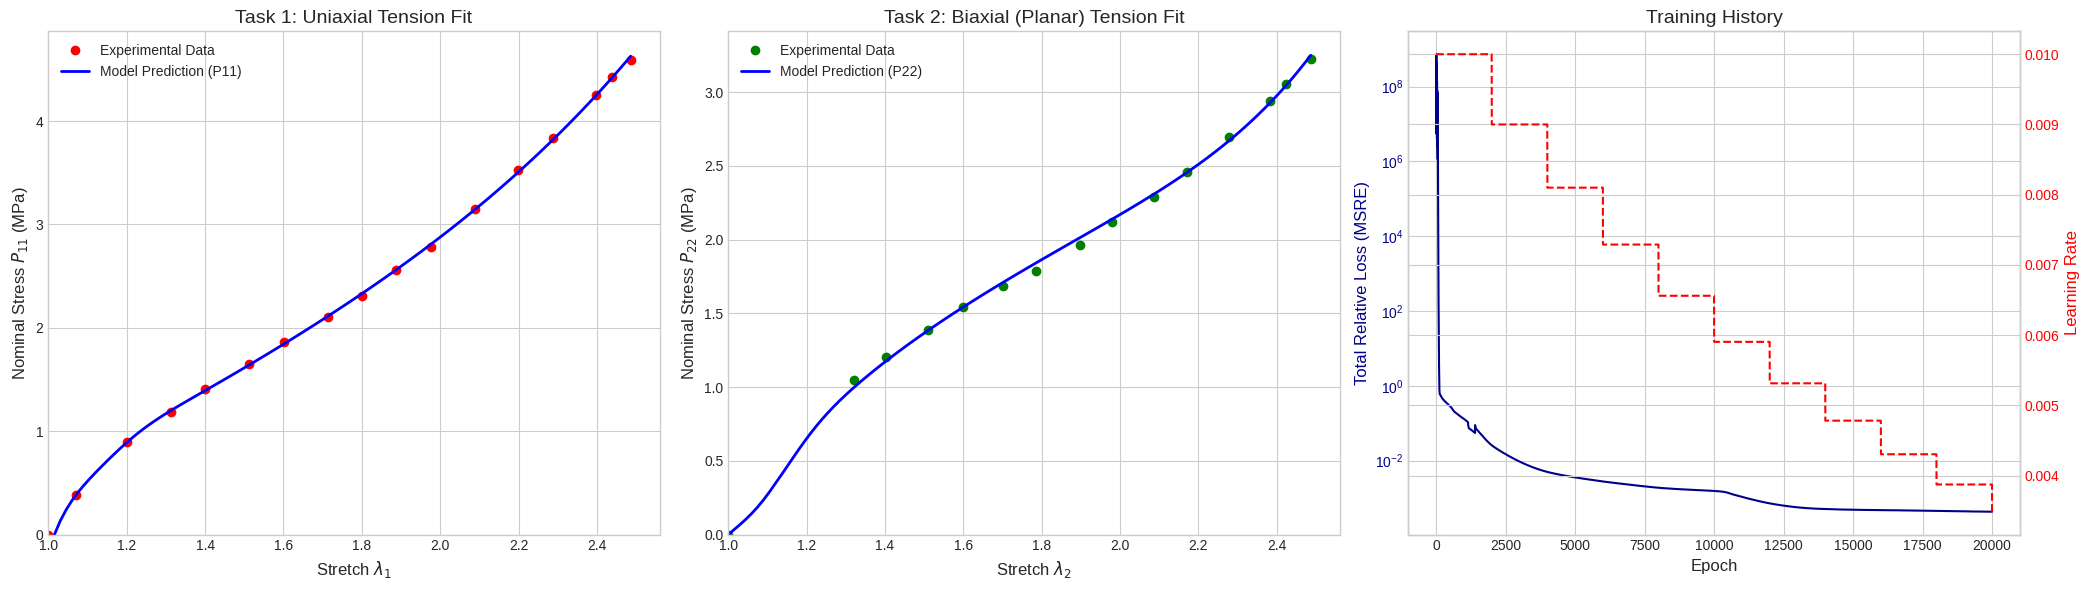

In [ ]:
!pip install tensorflow -q

import tensorflow as tf
import numpy as np
from io import StringIO
import pandas as pd
import matplotlib.pyplot as plt

# --- Setup, Model Definition, Helper/Physics Functions ---
# (This entire section remains identical to the previous correct version.
#  It includes the smooth_relu, the StrainEnergyANN_Layered_TF class,
#  get_invariants_tf, get_biaxial_stresses, and the robust
#  predict_biaxial_p22 using the bisection method.)

tf.keras.backend.set_floatx('float64')
DEVICE = "/GPU:0" if tf.config.list_physical_devices('GPU') else "/CPU:0"
print(f"Using device: {DEVICE}")

ARG_CLIP_MIN = tf.constant(-10.0, dtype=tf.float64)
ARG_CLIP_MAX = tf.constant(10.0, dtype=tf.float64)

@tf.function
def smooth_relu(x, beta=20.0):
    return tf.nn.softplus(beta * x) / beta

class StrainEnergyANN_Layered_TF(tf.keras.Model):
    def __init__(self):
        super().__init__(name="StrainEnergyModel")
        # k & i params (exponents) - All parameters are now trainable
        self.raw_log_k1=self.add_weight(name="raw_log_k1",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_k2=self.add_weight(name="raw_log_k2",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_k3=self.add_weight(name="raw_log_k3",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_k4=self.add_weight(name="raw_log_k4",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_k5=self.add_weight(name="raw_log_k5",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_k6=self.add_weight(name="raw_log_k6",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_k7=self.add_weight(name="raw_log_k7",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_k8=self.add_weight(name="raw_log_k8",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_k9=self.add_weight(name="raw_log_k9",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_k10=self.add_weight(name="raw_log_k10",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_k11=self.add_weight(name="raw_log_k11",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_k12=self.add_weight(name="raw_log_k12",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_k13=self.add_weight(name="raw_log_k13",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_k14=self.add_weight(name="raw_log_k14",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_k15=self.add_weight(name="raw_log_k15",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_k16=self.add_weight(name="raw_log_k16",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_i1=self.add_weight(name="raw_log_i1",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_i2=self.add_weight(name="raw_log_i2",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_i3=self.add_weight(name="raw_log_i3",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_i4=self.add_weight(name="raw_log_i4",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_i5=self.add_weight(name="raw_log_i5",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_i6=self.add_weight(name="raw_log_i6",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_i7=self.add_weight(name="raw_log_i7",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_i8=self.add_weight(name="raw_log_i8",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_a1=self.add_weight(name="raw_log_a1",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.1)),trainable=True)
        self.raw_log_a2=self.add_weight(name="raw_log_a2",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.1)),trainable=True)
        self.raw_log_a3=self.add_weight(name="raw_log_a3",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.1)),trainable=True)
        self.raw_log_a4=self.add_weight(name="raw_log_a4",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.1)),trainable=True)
        self.raw_log_a5=self.add_weight(name="raw_log_a5",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.1)),trainable=True)
        self.raw_log_a6=self.add_weight(name="raw_log_a6",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.1)),trainable=True)
        self.raw_log_a7=self.add_weight(name="raw_log_a7",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.1)),trainable=True)
        self.raw_log_a8=self.add_weight(name="raw_log_a8",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.1)),trainable=True)
        self.raw_log_b1=self.add_weight(name="raw_log_b1",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.01)),trainable=True)
        self.raw_log_b2=self.add_weight(name="raw_log_b2",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.01)),trainable=True)
        self.raw_log_b3=self.add_weight(name="raw_log_b3",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.1)),trainable=True)
        self.raw_log_b4=self.add_weight(name="raw_log_b4",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.1)),trainable=True)
        self.raw_log_b5=self.add_weight(name="raw_log_b5",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.1)),trainable=True)
        self.raw_log_b6=self.add_weight(name="raw_log_b6",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.1)),trainable=True)
        self.raw_log_b7=self.add_weight(name="raw_log_b7",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.1)),trainable=True)
        self.raw_log_b8=self.add_weight(name="raw_log_b8",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.1)),trainable=True)
        self.raw_log_a3_prime=self.add_weight(name="raw_log_a3_prime",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.2)),trainable=True)
        self.raw_log_a4_prime=self.add_weight(name="raw_log_a4_prime",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.2)),trainable=True)
        self.raw_log_a5_prime=self.add_weight(name="raw_log_a5_prime",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.2)),trainable=True)
        self.raw_log_a6_prime=self.add_weight(name="raw_log_a6_prime",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.2)),trainable=True)
        self.raw_log_a7_prime=self.add_weight(name="raw_log_a7_prime",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.2)),trainable=True)
        self.raw_log_a8_prime=self.add_weight(name="raw_log_a8_prime",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.2)),trainable=True)
        self.raw_log_b3_prime=self.add_weight(name="raw_log_b3_prime",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.2)),trainable=True)
        self.raw_log_b4_prime=self.add_weight(name="raw_log_b4_prime",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.2)),trainable=True)
        self.raw_log_b5_prime=self.add_weight(name="raw_log_b5_prime",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.2)),trainable=True)
        self.raw_log_b6_prime=self.add_weight(name="raw_log_b6_prime",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.2)),trainable=True)
        self.raw_log_b7_prime=self.add_weight(name="raw_log_b7_prime",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.2)),trainable=True)
        self.raw_log_b8_prime=self.add_weight(name="raw_log_b8_prime",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.2)),trainable=True)
        self.three=tf.constant(3.0,dtype=tf.float64); self.one=tf.constant(1.0,dtype=tf.float64); self.pow_base_epsilon=tf.constant(1e-8,dtype=tf.float64)
    def _term_power_law(self, I, k, i, c, ref_val):
        arg = smooth_relu(tf.pow(I, k) - tf.pow(ref_val, k))
        return c * tf.pow(arg + self.pow_base_epsilon, i)
    def _term_exponential(self, I, k, i, ic, oc, ref_val):
        arg = smooth_relu(tf.pow(I, k) - tf.pow(ref_val, k))
        return oc * (tf.exp(tf.clip_by_value(ic * tf.pow(arg + self.pow_base_epsilon, i), ARG_CLIP_MIN, ARG_CLIP_MAX)) - 1.0)
    def _term_cosh_minus_one_with_i(self, I, k, i, ic, oc, ref_val):
        arg = smooth_relu(tf.pow(I, k) - tf.pow(ref_val, k))
        return oc * (tf.cosh(tf.clip_by_value(ic * tf.pow(arg + self.pow_base_epsilon, i), ARG_CLIP_MIN, ARG_CLIP_MAX)) - 1.0)
    def _term_sinh_with_i(self, I, k, i, ic, oc, ref_val):
        arg = smooth_relu(tf.pow(I, k) - tf.pow(ref_val, k))
        return oc * tf.sinh(tf.clip_by_value(ic * tf.pow(arg + self.pow_base_epsilon, i), ARG_CLIP_MIN, ARG_CLIP_MAX))
    def _term_identity_scaled(self, I, k, c, ref_val): return c * (tf.pow(I, k) - tf.pow(ref_val, k))
    def _term_exponential_no_i(self, I, k, ic, oc, ref_val): return oc * (tf.exp(tf.clip_by_value(ic * (tf.pow(I, k) - tf.pow(ref_val, k)), ARG_CLIP_MIN, ARG_CLIP_MAX)) - 1.0)
    def _term_cosh_minus_one(self, I, k, ic, oc, ref_val): return oc * (tf.cosh(tf.clip_by_value(ic * (tf.pow(I, k) - tf.pow(ref_val, k)), ARG_CLIP_MIN, ARG_CLIP_MAX)) - 1.0)
    def _term_sinh(self, I, k, ic, oc, ref_val): return oc * tf.sinh(tf.clip_by_value(ic * (tf.pow(I, k) - tf.pow(ref_val, k)), ARG_CLIP_MIN, ARG_CLIP_MAX))
    def call(self, I1, I2, I4, I6):
        k1=1.0+tf.exp(self.raw_log_k1);k2=1.5+tf.exp(self.raw_log_k2);k3=1.0+tf.exp(self.raw_log_k3);k4=1.5+tf.exp(self.raw_log_k4);k5=1.0+tf.exp(self.raw_log_k5);k6=1.5+tf.exp(self.raw_log_k6);k7=1.0+tf.exp(self.raw_log_k7);k8=1.5+tf.exp(self.raw_log_k8);k9=1.0+tf.exp(self.raw_log_k9);k10=1.5+tf.exp(self.raw_log_k10);k11=1.0+tf.exp(self.raw_log_k11);k12=1.5+tf.exp(self.raw_log_k12);k13=1.0+tf.exp(self.raw_log_k13);k14=1.5+tf.exp(self.raw_log_k14);k15=1.0+tf.exp(self.raw_log_k15);k16=1.5+tf.exp(self.raw_log_k16)
        i1=1.0+tf.exp(self.raw_log_i1);i2=1.0+tf.exp(self.raw_log_i2);i3=1.0+tf.exp(self.raw_log_i3);i4=1.0+tf.exp(self.raw_log_i4);i5=1.0+tf.exp(self.raw_log_i5);i6=1.0+tf.exp(self.raw_log_i6);i7=1.0+tf.exp(self.raw_log_i7);i8=1.0+tf.exp(self.raw_log_i8)
        a1=tf.exp(self.raw_log_a1);a2=tf.exp(self.raw_log_a2);a3=tf.exp(self.raw_log_a3);a4=tf.exp(self.raw_log_a4);a5=tf.exp(self.raw_log_a5);a6=tf.exp(self.raw_log_a6);a7=tf.exp(self.raw_log_a7);a8=tf.exp(self.raw_log_a8)
        a3_prime=tf.exp(self.raw_log_a3_prime);a4_prime=tf.exp(self.raw_log_a4_prime);a5_prime=tf.exp(self.raw_log_a5_prime);a6_prime=tf.exp(self.raw_log_a6_prime);a7_prime=tf.exp(self.raw_log_a7_prime);a8_prime=tf.exp(self.raw_log_a8_prime)
        b1=tf.exp(self.raw_log_b1);b2=tf.exp(self.raw_log_b2);b3=tf.exp(self.raw_log_b3);b4=tf.exp(self.raw_log_b4);b5=tf.exp(self.raw_log_b5);b6=tf.exp(self.raw_log_b6);b7=tf.exp(self.raw_log_b7);b8=tf.exp(self.raw_log_b8)
        b3_prime=tf.exp(self.raw_log_b3_prime);b4_prime=tf.exp(self.raw_log_b4_prime);b5_prime=tf.exp(self.raw_log_b5_prime);b6_prime=tf.exp(self.raw_log_b6_prime);b7_prime=tf.exp(self.raw_log_b7_prime);b8_prime=tf.exp(self.raw_log_b8_prime)
        W = tf.zeros_like(I1,dtype=tf.float64)
        W += self._term_power_law(I1,k1,i1,a1,self.three); W += self._term_power_law(I2,k2,i2,a2,self.three)
        W += self._term_exponential(I1,k3,i3,a3_prime,a3,self.three); W += self._term_exponential(I2,k4,i4,a4_prime,a4,self.three)
        W += self._term_cosh_minus_one_with_i(I1,k5,i5,a5_prime,a5,self.three); W += self._term_cosh_minus_one_with_i(I2,k6,i6,a6_prime,a6,self.three)
        W += self._term_sinh_with_i(I1,k7,i7,a7_prime,a7,self.three); W += self._term_sinh_with_i(I2,k8,i8,a8_prime,a8,self.three)
        W += self._term_identity_scaled(I4,k9,b1,self.one); W += self._term_identity_scaled(I6,k10,b2,self.one)
        W += self._term_exponential_no_i(I4,k11,b3_prime,b3,self.one); W += self._term_exponential_no_i(I6,k12,b4_prime,b4,self.one)
        W += self._term_cosh_minus_one(I4,k13,b5_prime,b5,self.one); W += self._term_cosh_minus_one(I6,k14,b6_prime,b6,self.one)
        W += self._term_sinh(I4,k15,b7_prime,b7,self.one); W += self._term_sinh(I6,k16,b8_prime,b8,self.one)
        return W

@tf.function
def get_invariants_tf(lambda1, lambda2, lambda3):
    min_lambda_val = tf.constant(1e-6, dtype=tf.float64)
    lambda1 = tf.maximum(lambda1, min_lambda_val)
    lambda2 = tf.maximum(lambda2, min_lambda_val)
    lambda3 = tf.maximum(lambda3, min_lambda_val)
    l1s = tf.pow(lambda1, 2.0); l2s = tf.pow(lambda2, 2.0); l3s = tf.pow(lambda3, 2.0)
    I1 = l1s + l2s + l3s
    I2 = tf.pow(lambda1 * lambda2, 2.0) + tf.pow(lambda2 * lambda3, 2.0) + tf.pow(lambda3 * lambda1, 2.0)
    I4 = l1s; I6 = tf.pow(lambda1, -4.0)
    return I1, I2, I4, I6

@tf.function
def predict_uniaxial_p11(lambda1, model):
    l1 = lambda1
    with tf.GradientTape(persistent=True) as tape:
        l1_t = tf.identity(l1)
        l2_t = tf.pow(l1_t, -0.5)
        l3_t = tf.pow(l1_t, -0.5)
        tape.watch([l1_t, l3_t])
        I1, I2, I4, I6 = get_invariants_tf(l1_t, l2_t, l3_t)
        W = model(I1, I2, I4, I6)
    dW_d_lambdas = tape.gradient(W, [l1_t, l3_t])
    dWdl1, dWdl3 = dW_d_lambdas[0], dW_d_lambdas[1]
    del tape
    p = l3_t * dWdl3
    P11 = dWdl1 - p / l1_t
    return P11

@tf.function
def get_biaxial_stresses(l1, l2, model):
    with tf.GradientTape(persistent=True) as tape:
        l1_t = tf.identity(l1); l2_t = tf.identity(l2)
        l3_t = 1.0 / (l1_t * l2_t)
        tape.watch([l1_t, l2_t, l3_t])
        I1, I2, I4, I6 = get_invariants_tf(l1_t, l2_t, l3_t)
        W = model(I1, I2, I4, I6)
    dW_d_lambdas = tape.gradient(W, [l1_t, l2_t, l3_t])
    dWdl1, dWdl2, dWdl3 = dW_d_lambdas[0], dW_d_lambdas[1], dW_d_lambdas[2]
    del tape
    p = l3_t * dWdl3
    P11 = dWdl1 - p / l1_t
    P22 = dWdl2 - p / l2_t
    return P11, P22

@tf.function
def predict_biaxial_p22(lambda2, model):
    l1_min = tf.ones_like(lambda2, dtype=tf.float64) * 0.1
    l1_max = tf.ones_like(lambda2, dtype=tf.float64) * 1.0
    for _ in range(20):
        l1_mid = (l1_min + l1_max) / 2.0
        p11_mid, _ = get_biaxial_stresses(l1_mid, lambda2, model)
        p11_min, _ = get_biaxial_stresses(l1_min, lambda2, model)
        is_same_sign = tf.sign(p11_mid) == tf.sign(p11_min)
        l1_min = tf.where(is_same_sign, l1_mid, l1_min)
        l1_max = tf.where(is_same_sign, l1_max, l1_mid)
    final_l1 = tf.stop_gradient((l1_min + l1_max) / 2.0)
    _, P22_final = get_biaxial_stresses(final_l1, lambda2, model)
    return P22_final

# --- Experimental Data ---
exp_data_raw_uniaxial_cnf = np.array([
    [1.0000, 0], [1.0708, 0.3840], [1.2017, 0.8987], [1.3125, 1.1814], [1.4000, 1.4093],
    [1.5125, 1.6456], [1.6017, 1.8608], [1.7125, 2.1055], [1.8008, 2.3122], [1.8883, 2.5570],
    [1.9767, 2.7848], [2.0883, 3.1519], [2.1992, 3.5274], [2.2867, 3.8354], [2.3975, 4.2532],
    [2.4383, 4.4304], [2.4858, 4.5949]
])
exp_data_raw_biaxial_cnf = np.array([
    [1.0000, 0], [1.3208, 1.0506], [1.4017, 1.2068], [1.5092, 1.3840], [1.5983, 1.5401],
    [1.7017, 1.6835], [1.7842, 1.7848], [1.8967, 1.9662], [1.9792, 2.1181], [2.0858, 2.2911],
    [2.1708, 2.4599], [2.2783, 2.6962], [2.3825, 2.9409], [2.4225, 3.0549], [2.4867, 3.2236]
])
uniaxial_l1, uniaxial_p11 = [tf.constant(c, dtype=tf.float64) for c in exp_data_raw_uniaxial_cnf.T]
biaxial_l2, biaxial_p22 = [tf.constant(c, dtype=tf.float64) for c in exp_data_raw_biaxial_cnf.T]

# --- Training with IMPROVED LOSS FUNCTION ---

model = StrainEnergyANN_Layered_TF()

initial_learning_rate = 0.01
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=2000, decay_rate=0.9, staircase=True)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

# --- CHANGE 1: USE A SIMPLE 1.0 WEIGHT FOR RELATIVE ERROR ---
# Since we are now using relative error, the scales of the two losses
# are naturally balanced. A complex weight is no longer needed.
# We weight both tasks equally.
loss_weight_biaxial = tf.constant(1.0, dtype=tf.float64)
print(f"Biaxial Loss Weight (using relative error): {loss_weight_biaxial.numpy():.2f}")

loss_history = []
learning_rate_history = []

# --- CHANGE 2: IMPLEMENT MEAN SQUARED RELATIVE ERROR (MSRE) LOSS ---
@tf.function
def train_step(uniaxial_l1, uniaxial_p11, biaxial_l2, biaxial_p22, loss_weight):
    with tf.GradientTape() as tape:
        # --- Uniaxial Loss (Task 1) ---
        p11_pred = predict_uniaxial_p11(uniaxial_l1, model)
        # We slice with [1:] to exclude the first data point (stress=0)
        # to prevent division by zero when calculating relative error.
        relative_error_1 = (p11_pred[1:] - uniaxial_p11[1:]) / uniaxial_p11[1:]
        loss1 = tf.reduce_mean(tf.square(relative_error_1))

        # --- Biaxial Loss (Task 2) ---
        p22_pred = predict_biaxial_p22(biaxial_l2, model)
        # Similarly, slice with [1:] to avoid division by zero.
        relative_error_2 = (p22_pred[1:] - biaxial_p22[1:]) / biaxial_p22[1:]
        loss2 = tf.reduce_mean(tf.square(relative_error_2))

        # The new total loss now balances the *percentage* error of both tasks.
        total_loss = loss1 + loss_weight * loss2

    grads = tape.gradient(total_loss, model.trainable_variables)
    grads = [tf.clip_by_value(g, -1.0, 1.0) if g is not None else g for g in grads]
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    return total_loss, loss1, loss2


epochs = 20000
for epoch in range(epochs):
    total_loss, loss1, loss2 = train_step(uniaxial_l1, uniaxial_p11, biaxial_l2, biaxial_p22, loss_weight_biaxial)
    loss_history.append(total_loss.numpy())
    current_lr = lr_schedule(optimizer.iterations)
    learning_rate_history.append(current_lr.numpy())
    if epoch % 1000 == 0:
        print(f"Epoch {epoch:5d}, Relative Loss: {total_loss:.4f} (Uni: {loss1:.4f}, Bi: {loss2:.4f}), LR: {current_lr:.6f}")

print(f"\nTraining finished. Final Relative Loss: {loss_history[-1]:.4f}")

# --- Visualization (No changes needed here) ---

l1_plot = np.linspace(1.0, exp_data_raw_uniaxial_cnf[:, 0].max(), 100)
p11_pred_plot = predict_uniaxial_p11(tf.constant(l1_plot, dtype=tf.float64), model).numpy()

l2_plot = np.linspace(1.0, exp_data_raw_biaxial_cnf[:, 0].max(), 100)
p22_pred_plot = predict_biaxial_p22(tf.constant(l2_plot, dtype=tf.float64), model).numpy()

plt.style.use('seaborn-v0_8-whitegrid')
fig, axes = plt.subplots(1, 3, figsize=(21, 6))

axes[0].plot(exp_data_raw_uniaxial_cnf[:, 0], exp_data_raw_uniaxial_cnf[:, 1], 'ro', label='Experimental Data')
axes[0].plot(l1_plot, p11_pred_plot, 'b-', lw=2, label='Model Prediction (P11)')
axes[0].set_xlabel('Stretch $\\lambda_1$', fontsize=12)
axes[0].set_ylabel('Nominal Stress $P_{11}$ (MPa)', fontsize=12)
axes[0].set_title('Task 1: Uniaxial Tension Fit', fontsize=14)
axes[0].legend()
axes[0].set_ylim(bottom=0); axes[0].set_xlim(left=1)

axes[1].plot(exp_data_raw_biaxial_cnf[:, 0], exp_data_raw_biaxial_cnf[:, 1], 'go', label='Experimental Data')
axes[1].plot(l2_plot, p22_pred_plot, 'b-', lw=2, label='Model Prediction (P22)')
axes[1].set_xlabel('Stretch $\\lambda_2$', fontsize=12)
axes[1].set_ylabel('Nominal Stress $P_{22}$ (MPa)', fontsize=12)
axes[1].set_title('Task 2: Biaxial (Planar) Tension Fit', fontsize=14)
axes[1].legend()
axes[1].set_ylim(bottom=0); axes[1].set_xlim(left=1)

ax2 = axes[2]
ax2.plot(loss_history, label='Total Loss', color='darkblue')
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Total Relative Loss (MSRE)', fontsize=12, color='darkblue')
ax2.set_title('Training History', fontsize=14)
ax2.set_yscale('log')
ax2.tick_params(axis='y', labelcolor='darkblue')

ax3 = ax2.twinx()
ax3.plot(learning_rate_history, label='Learning Rate', color='red', linestyle='--')
ax3.set_ylabel('Learning Rate', fontsize=12, color='red')
ax3.tick_params(axis='y', labelcolor='red')

fig.tight_layout()
plt.show()

## Calender with Constriants

Using device: /CPU:0
Biaxial Loss Weight: 1.00
Zero-Stress Penalty Weight: 100.00
Epoch     0, Loss: 373999206.6272 (Uni: 182277697.4553, Bi: 191721509.1719, Zero: 0.000000), LR: 0.010000
Epoch  1000, Loss: 0.0575 (Uni: 0.0368, Bi: 0.0208, Zero: 0.000000), LR: 0.010000
Epoch  2000, Loss: 0.0108 (Uni: 0.0083, Bi: 0.0025, Zero: 0.000000), LR: 0.009000
Epoch  3000, Loss: 0.0060 (Uni: 0.0046, Bi: 0.0014, Zero: 0.000000), LR: 0.009000
Epoch  4000, Loss: 0.0043 (Uni: 0.0028, Bi: 0.0015, Zero: 0.000000), LR: 0.008100
Epoch  5000, Loss: 0.0045 (Uni: 0.0010, Bi: 0.0035, Zero: 0.000000), LR: 0.008100
Epoch  6000, Loss: 0.0042 (Uni: 0.0002, Bi: 0.0040, Zero: 0.000000), LR: 0.007290
Epoch  7000, Loss: 0.0033 (Uni: 0.0001, Bi: 0.0032, Zero: 0.000000), LR: 0.007290
Epoch  8000, Loss: 0.0024 (Uni: 0.0001, Bi: 0.0024, Zero: 0.000000), LR: 0.006561
Epoch  9000, Loss: 0.0019 (Uni: 0.0000, Bi: 0.0019, Zero: 0.000000), LR: 0.006561
Epoch 10000, Loss: 0.0016 (Uni: 0.0000, Bi: 0.0016, Zero: 0.000000), LR: 0

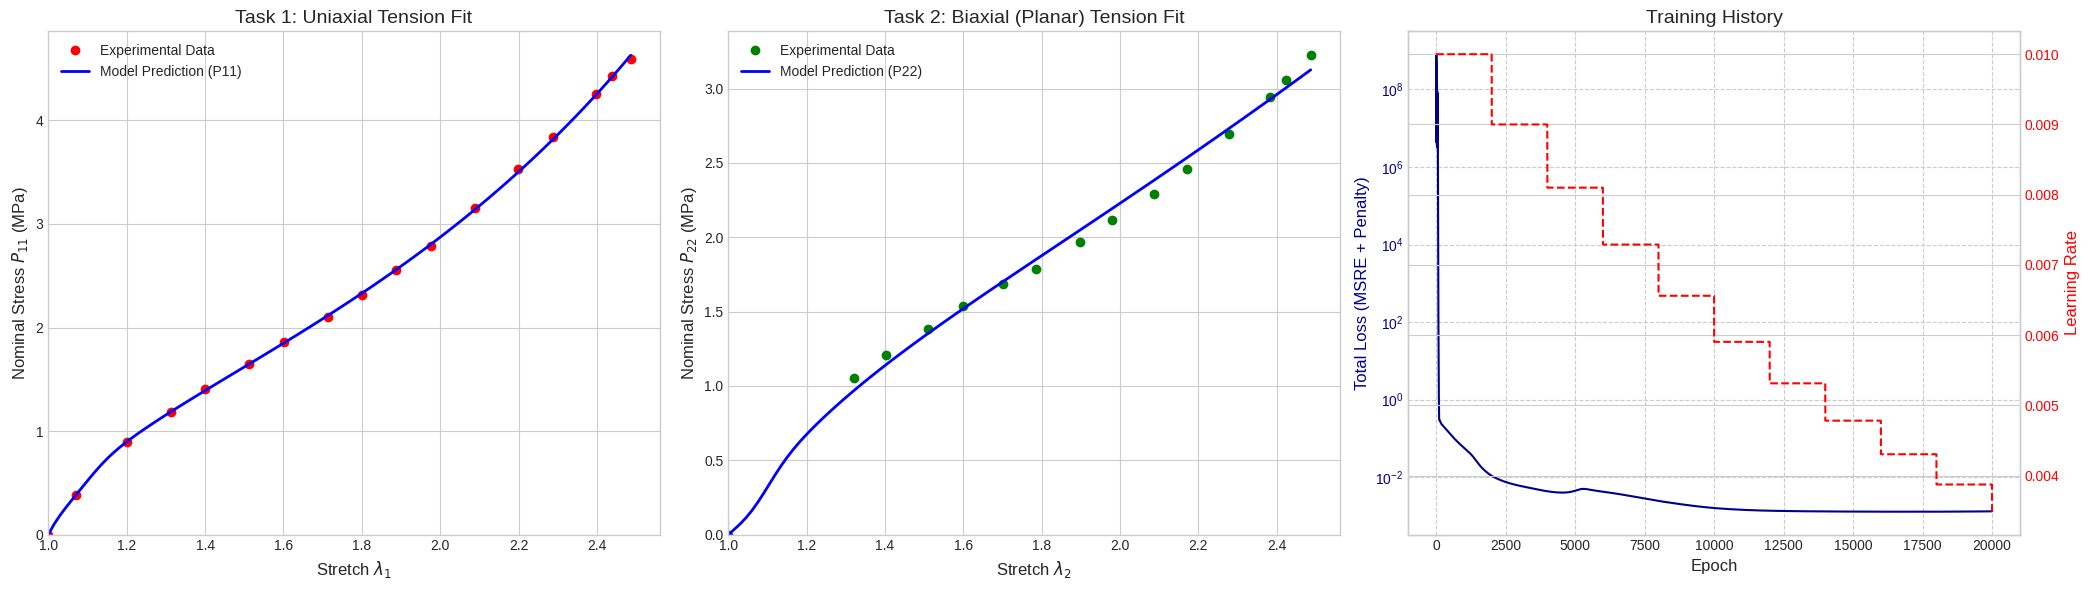


Final check:
P11 at lambda1=1: -8.614625e-10
P22 at lambda2=1: 1.869966e-08


In [ ]:
!pip install tensorflow -q
!pip install -U "seaborn" --quiet

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# --- Setup, Model Definition, Helper/Physics Functions ---
tf.keras.backend.set_floatx('float64')
DEVICE = "/GPU:0" if tf.config.list_physical_devices('GPU') else "/CPU:0"
print(f"Using device: {DEVICE}")

ARG_CLIP_MIN = tf.constant(-10.0, dtype=tf.float64)
ARG_CLIP_MAX = tf.constant(10.0, dtype=tf.float64)

@tf.function
def smooth_relu(x, beta=20.0):
    """A smooth, differentiable approximation of the ReLU function."""
    return tf.nn.softplus(beta * x) / beta

class StrainEnergyANN_Layered_TF(tf.keras.Model):
    def __init__(self):
        super().__init__(name="StrainEnergyModel")
        # --- MODIFICATION: REMOVE b1 FROM TRAINABLE PARAMETERS ---
        # b1 will be calculated from the other parameters to enforce the constraint.
        # self.raw_log_b1 = self.add_weight(...) # This line is removed.

        # k & i params (exponents) - All other parameters remain trainable
        self.raw_log_k1=self.add_weight(name="raw_log_k1",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_k2=self.add_weight(name="raw_log_k2",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_k3=self.add_weight(name="raw_log_k3",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_k4=self.add_weight(name="raw_log_k4",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_k5=self.add_weight(name="raw_log_k5",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_k6=self.add_weight(name="raw_log_k6",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_k7=self.add_weight(name="raw_log_k7",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_k8=self.add_weight(name="raw_log_k8",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_k9=self.add_weight(name="raw_log_k9",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_k10=self.add_weight(name="raw_log_k10",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_k11=self.add_weight(name="raw_log_k11",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_k12=self.add_weight(name="raw_log_k12",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_k13=self.add_weight(name="raw_log_k13",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_k14=self.add_weight(name="raw_log_k14",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_k15=self.add_weight(name="raw_log_k15",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_k16=self.add_weight(name="raw_log_k16",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_i1=self.add_weight(name="raw_log_i1",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_i2=self.add_weight(name="raw_log_i2",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_i3=self.add_weight(name="raw_log_i3",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_i4=self.add_weight(name="raw_log_i4",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_i5=self.add_weight(name="raw_log_i5",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_i6=self.add_weight(name="raw_log_i6",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_i7=self.add_weight(name="raw_log_i7",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_i8=self.add_weight(name="raw_log_i8",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_a1=self.add_weight(name="raw_log_a1",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.1)),trainable=True)
        self.raw_log_a2=self.add_weight(name="raw_log_a2",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.1)),trainable=True)
        self.raw_log_a3=self.add_weight(name="raw_log_a3",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.1)),trainable=True)
        self.raw_log_a4=self.add_weight(name="raw_log_a4",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.1)),trainable=True)
        self.raw_log_a5=self.add_weight(name="raw_log_a5",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.1)),trainable=True)
        self.raw_log_a6=self.add_weight(name="raw_log_a6",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.1)),trainable=True)
        self.raw_log_a7=self.add_weight(name="raw_log_a7",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.1)),trainable=True)
        self.raw_log_a8=self.add_weight(name="raw_log_a8",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.1)),trainable=True)
        self.raw_log_b2=self.add_weight(name="raw_log_b2",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.01)),trainable=True)
        self.raw_log_b3=self.add_weight(name="raw_log_b3",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.1)),trainable=True)
        self.raw_log_b4=self.add_weight(name="raw_log_b4",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.1)),trainable=True)
        self.raw_log_b5=self.add_weight(name="raw_log_b5",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.1)),trainable=True)
        self.raw_log_b6=self.add_weight(name="raw_log_b6",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.1)),trainable=True)
        self.raw_log_b7=self.add_weight(name="raw_log_b7",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.1)),trainable=True)
        self.raw_log_b8=self.add_weight(name="raw_log_b8",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.1)),trainable=True)
        self.raw_log_a3_prime=self.add_weight(name="raw_log_a3_prime",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.2)),trainable=True)
        self.raw_log_a4_prime=self.add_weight(name="raw_log_a4_prime",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.2)),trainable=True)
        self.raw_log_a5_prime=self.add_weight(name="raw_log_a5_prime",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.2)),trainable=True)
        self.raw_log_a6_prime=self.add_weight(name="raw_log_a6_prime",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.2)),trainable=True)
        self.raw_log_a7_prime=self.add_weight(name="raw_log_a7_prime",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.2)),trainable=True)
        self.raw_log_a8_prime=self.add_weight(name="raw_log_a8_prime",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.2)),trainable=True)
        self.raw_log_b3_prime=self.add_weight(name="raw_log_b3_prime",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.2)),trainable=True)
        self.raw_log_b4_prime=self.add_weight(name="raw_log_b4_prime",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.2)),trainable=True)
        self.raw_log_b5_prime=self.add_weight(name="raw_log_b5_prime",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.2)),trainable=True)
        self.raw_log_b6_prime=self.add_weight(name="raw_log_b6_prime",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.2)),trainable=True)
        self.raw_log_b7_prime=self.add_weight(name="raw_log_b7_prime",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.2)),trainable=True)
        self.raw_log_b8_prime=self.add_weight(name="raw_log_b8_prime",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.2)),trainable=True)

        self.three=tf.constant(3.0,dtype=tf.float64)
        self.one=tf.constant(1.0,dtype=tf.float64)
        self.pow_base_epsilon=tf.constant(1e-8,dtype=tf.float64)

    def _term_power_law(self, I, k, i, c, ref_val):
        arg = smooth_relu(tf.pow(I, k) - tf.pow(ref_val, k))
        return c * tf.pow(arg + self.pow_base_epsilon, i)
    def _term_exponential(self, I, k, i, ic, oc, ref_val):
        arg = smooth_relu(tf.pow(I, k) - tf.pow(ref_val, k))
        return oc * (tf.exp(tf.clip_by_value(ic * tf.pow(arg + self.pow_base_epsilon, i), ARG_CLIP_MIN, ARG_CLIP_MAX)) - 1.0)
    def _term_cosh_minus_one_with_i(self, I, k, i, ic, oc, ref_val):
        arg = smooth_relu(tf.pow(I, k) - tf.pow(ref_val, k))
        return oc * (tf.cosh(tf.clip_by_value(ic * tf.pow(arg + self.pow_base_epsilon, i), ARG_CLIP_MIN, ARG_CLIP_MAX)) - 1.0)
    def _term_sinh_with_i(self, I, k, i, ic, oc, ref_val):
        arg = smooth_relu(tf.pow(I, k) - tf.pow(ref_val, k))
        return oc * tf.sinh(tf.clip_by_value(ic * tf.pow(arg + self.pow_base_epsilon, i), ARG_CLIP_MIN, ARG_CLIP_MAX))
    def _term_identity_scaled(self, I, k, c, ref_val):
        return c * (tf.pow(I, k) - tf.pow(ref_val, k))
    def _term_exponential_no_i(self, I, k, ic, oc, ref_val):
        return oc * (tf.exp(tf.clip_by_value(ic * (tf.pow(I, k) - tf.pow(ref_val, k)), ARG_CLIP_MIN, ARG_CLIP_MAX)) - 1.0)
    def _term_cosh_minus_one(self, I, k, ic, oc, ref_val):
        return oc * (tf.cosh(tf.clip_by_value(ic * (tf.pow(I, k) - tf.pow(ref_val, k)), ARG_CLIP_MIN, ARG_CLIP_MAX)) - 1.0)
    def _term_sinh(self, I, k, ic, oc, ref_val):
        return oc * tf.sinh(tf.clip_by_value(ic * (tf.pow(I, k) - tf.pow(ref_val, k)), ARG_CLIP_MIN, ARG_CLIP_MAX))

    def call(self, I1, I2, I4, I6):
        k1=1.0+tf.exp(self.raw_log_k1);k2=1.5+tf.exp(self.raw_log_k2);k3=1.0+tf.exp(self.raw_log_k3);k4=1.5+tf.exp(self.raw_log_k4);k5=1.0+tf.exp(self.raw_log_k5);k6=1.5+tf.exp(self.raw_log_k6);k7=1.0+tf.exp(self.raw_log_k7);k8=1.5+tf.exp(self.raw_log_k8);k9=1.0+tf.exp(self.raw_log_k9);k10=1.5+tf.exp(self.raw_log_k10);k11=1.0+tf.exp(self.raw_log_k11);k12=1.5+tf.exp(self.raw_log_k12);k13=1.0+tf.exp(self.raw_log_k13);k14=1.5+tf.exp(self.raw_log_k14);k15=1.0+tf.exp(self.raw_log_k15);k16=1.5+tf.exp(self.raw_log_k16)
        i1=1.0+tf.exp(self.raw_log_i1);i2=1.0+tf.exp(self.raw_log_i2);i3=1.0+tf.exp(self.raw_log_i3);i4=1.0+tf.exp(self.raw_log_i4);i5=1.0+tf.exp(self.raw_log_i5);i6=1.0+tf.exp(self.raw_log_i6);i7=1.0+tf.exp(self.raw_log_i7);i8=1.0+tf.exp(self.raw_log_i8)
        a1=tf.exp(self.raw_log_a1);a2=tf.exp(self.raw_log_a2);a3=tf.exp(self.raw_log_a3);a4=tf.exp(self.raw_log_a4);a5=tf.exp(self.raw_log_a5);a6=tf.exp(self.raw_log_a6);a7=tf.exp(self.raw_log_a7);a8=tf.exp(self.raw_log_a8)
        a3_prime=tf.exp(self.raw_log_a3_prime);a4_prime=tf.exp(self.raw_log_a4_prime);a5_prime=tf.exp(self.raw_log_a5_prime);a6_prime=tf.exp(self.raw_log_a6_prime);a7_prime=tf.exp(self.raw_log_a7_prime);a8_prime=tf.exp(self.raw_log_a8_prime)

        b2=tf.exp(self.raw_log_b2);b3=tf.exp(self.raw_log_b3);b4=tf.exp(self.raw_log_b4);b5=tf.exp(self.raw_log_b5);b6=tf.exp(self.raw_log_b6);b7=tf.exp(self.raw_log_b7);b8=tf.exp(self.raw_log_b8)
        b3_prime=tf.exp(self.raw_log_b3_prime);b4_prime=tf.exp(self.raw_log_b4_prime);b5_prime=tf.exp(self.raw_log_b5_prime);b6_prime=tf.exp(self.raw_log_b6_prime);b7_prime=tf.exp(self.raw_log_b7_prime);b8_prime=tf.exp(self.raw_log_b8_prime)

        # --- MODIFICATION: ENFORCE CONSTRAINT VIA REPARAMETERIZATION ---
        rhs = (b2 * k10) + (b4 * b4_prime * k12) + (b8 * b8_prime * k16)
        lhs_sub = (b3 * b3_prime * k11) + (b7 * b7_prime * k15)
        # k9 is guaranteed to be > 1.0, so division is safe. Add a small epsilon for absolute stability.
        b1 = (rhs - lhs_sub) / (k9 + 1e-8)

        W = tf.zeros_like(I1,dtype=tf.float64)
        W += self._term_power_law(I1,k1,i1,a1,self.three); W += self._term_power_law(I2,k2,i2,a2,self.three)
        W += self._term_exponential(I1,k3,i3,a3_prime,a3,self.three); W += self._term_exponential(I2,k4,i4,a4_prime,a4,self.three)
        W += self._term_cosh_minus_one_with_i(I1,k5,i5,a5_prime,a5,self.three); W += self._term_cosh_minus_one_with_i(I2,k6,i6,a6_prime,a6,self.three)
        W += self._term_sinh_with_i(I1,k7,i7,a7_prime,a7,self.three); W += self._term_sinh_with_i(I2,k8,i8,a8_prime,a8,self.three)
        # Use the computed b1 here
        W += self._term_identity_scaled(I4,k9,b1,self.one); W += self._term_identity_scaled(I6,k10,b2,self.one)
        W += self._term_exponential_no_i(I4,k11,b3_prime,b3,self.one); W += self._term_exponential_no_i(I6,k12,b4_prime,b4,self.one)
        W += self._term_cosh_minus_one(I4,k13,b5_prime,b5,self.one); W += self._term_cosh_minus_one(I6,k14,b6_prime,b6,self.one)
        W += self._term_sinh(I4,k15,b7_prime,b7,self.one); W += self._term_sinh(I6,k16,b8_prime,b8,self.one)
        return W

@tf.function
def get_invariants_tf(lambda1, lambda2, lambda3):
    min_lambda_val = tf.constant(1e-6, dtype=tf.float64)
    lambda1 = tf.maximum(lambda1, min_lambda_val)
    lambda2 = tf.maximum(lambda2, min_lambda_val)
    lambda3 = tf.maximum(lambda3, min_lambda_val)
    l1s = tf.pow(lambda1, 2.0); l2s = tf.pow(lambda2, 2.0); l3s = tf.pow(lambda3, 2.0)
    I1 = l1s + l2s + l3s
    I2 = tf.pow(lambda1 * lambda2, 2.0) + tf.pow(lambda2 * lambda3, 2.0) + tf.pow(lambda3 * lambda1, 2.0)
    I4 = l1s
    # I6 has an alternative definition depending on fiber orientation. Assuming a_0 = [1,0,0]
    I6 = 1/l1s
    return I1, I2, I4, I6

@tf.function
def predict_uniaxial_p11(lambda1, model):
    l1 = lambda1
    with tf.GradientTape(persistent=True) as tape:
        l1_t = tf.identity(l1)
        # Incompressible material: lambda1 * lambda2 * lambda3 = 1
        l2_t = tf.pow(l1_t, -0.5)
        l3_t = tf.pow(l1_t, -0.5)
        tape.watch([l1_t, l2_t, l3_t])
        I1, I2, I4, I6 = get_invariants_tf(l1_t, l2_t, l3_t)
        W = model(I1, I2, I4, I6)

    dWdl1 = tape.gradient(W, l1_t)
    dWdl2 = tape.gradient(W, l2_t)
    dWdl3 = tape.gradient(W, l3_t)
    del tape

    # Cauchy stress T = (2/J) * [ (dW/dI1 + I1*dW/dI2)*B - (dW/dI2)*B^2 ... ] * F^T
    # For uniaxial, P11 = 2 * (l1 - 1/l1^2) * (dW/dI1 + 1/l1 * dW/dI2) + 2 * (l1-1/l1^2)*dW/dI4
    # A more direct approach using principal stresses for incompressible materials:
    # P_ii = dW/d_lambda_i - p / lambda_i
    # For uniaxial test, P22 = P33 = 0. So p = lambda2 * dW/d_lambda2 = lambda3 * dW/d_lambda3
    p = l2_t * dWdl2
    P11 = dWdl1 - p / l1_t
    return P11

@tf.function
def get_biaxial_stresses(l1, l2, model):
    with tf.GradientTape(persistent=True) as tape:
        l1_t = tf.identity(l1)
        l2_t = tf.identity(l2)
        # Incompressible material: lambda1 * lambda2 * lambda3 = 1
        l3_t = 1.0 / (l1_t * l2_t)
        tape.watch([l1_t, l2_t, l3_t])
        I1, I2, I4, I6 = get_invariants_tf(l1_t, l2_t, l3_t)
        W = model(I1, I2, I4, I6)

    dWdl1 = tape.gradient(W, l1_t)
    dWdl2 = tape.gradient(W, l2_t)
    dWdl3 = tape.gradient(W, l3_t)
    del tape

    # For planar tension, P33 = 0. So p = lambda3 * dW/d_lambda3
    p = l3_t * dWdl3
    P11 = dWdl1 - p / l1_t
    P22 = dWdl2 - p / l2_t
    return P11, P22

@tf.function
def predict_biaxial_p22(lambda2, model):
    l1_min = tf.ones_like(lambda2, dtype=tf.float64) * 0.5
    l1_max = tf.ones_like(lambda2, dtype=tf.float64) * 1.5

    # Use bisection method to find lambda1 such that P11=0
    for _ in range(25): # Increased iterations for better precision
        l1_mid = (l1_min + l1_max) / 2.0
        p11_mid, _ = get_biaxial_stresses(l1_mid, lambda2, model)
        p11_min, _ = get_biaxial_stresses(l1_min, lambda2, model)

        is_same_sign = tf.sign(p11_mid) == tf.sign(p11_min)
        l1_min = tf.where(is_same_sign, l1_mid, l1_min)
        l1_max = tf.where(is_same_sign, l1_max, l1_mid)

    final_l1 = tf.stop_gradient((l1_min + l1_max) / 2.0)
    _, P22_final = get_biaxial_stresses(final_l1, lambda2, model)
    return P22_final

# --- Experimental Data ---
exp_data_raw_uniaxial_cnf = np.array([
    [1.0000, 0], [1.0708, 0.3840], [1.2017, 0.8987], [1.3125, 1.1814], [1.4000, 1.4093],
    [1.5125, 1.6456], [1.6017, 1.8608], [1.7125, 2.1055], [1.8008, 2.3122], [1.8883, 2.5570],
    [1.9767, 2.7848], [2.0883, 3.1519], [2.1992, 3.5274], [2.2867, 3.8354], [2.3975, 4.2532],
    [2.4383, 4.4304], [2.4858, 4.5949]
])
exp_data_raw_biaxial_cnf = np.array([
    [1.0000, 0], [1.3208, 1.0506], [1.4017, 1.2068], [1.5092, 1.3840], [1.5983, 1.5401],
    [1.7017, 1.6835], [1.7842, 1.7848], [1.8967, 1.9662], [1.9792, 2.1181], [2.0858, 2.2911],
    [2.1708, 2.4599], [2.2783, 2.6962], [2.3825, 2.9409], [2.4225, 3.0549], [2.4867, 3.2236]
])
uniaxial_l1, uniaxial_p11 = [tf.constant(c, dtype=tf.float64) for c in exp_data_raw_uniaxial_cnf.T]
biaxial_l2, biaxial_p22 = [tf.constant(c, dtype=tf.float64) for c in exp_data_raw_biaxial_cnf.T]

# --- Training with CONSTRAINED & IMPROVED LOSS FUNCTION ---

model = StrainEnergyANN_Layered_TF()

initial_learning_rate = 0.01
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=2000, decay_rate=0.9, staircase=True)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

loss_weight_biaxial = tf.constant(1.0, dtype=tf.float64)
# --- MODIFICATION: ADD WEIGHT FOR THE NEW ZERO-STRESS PENALTY ---
zero_stress_weight = tf.constant(100.0, dtype=tf.float64)

print(f"Biaxial Loss Weight: {loss_weight_biaxial.numpy():.2f}")
print(f"Zero-Stress Penalty Weight: {zero_stress_weight.numpy():.2f}")

loss_history = []
learning_rate_history = []

@tf.function
def train_step(uniaxial_l1, uniaxial_p11, biaxial_l2, biaxial_p22, loss_weight, zero_stress_weight):
    with tf.GradientTape() as tape:
        # --- Uniaxial Loss (Task 1) ---
        p11_pred = predict_uniaxial_p11(uniaxial_l1, model)
        # Slice with [1:] to exclude the first data point (stress=0) to prevent division by zero.
        relative_error_1 = (p11_pred[1:] - uniaxial_p11[1:]) / uniaxial_p11[1:]
        loss1 = tf.reduce_mean(tf.square(relative_error_1))

        # --- Biaxial Loss (Task 2) ---
        p22_pred = predict_biaxial_p22(biaxial_l2, model)
        # Similarly, slice with [1:] to avoid division by zero.
        relative_error_2 = (p22_pred[1:] - biaxial_p22[1:]) / biaxial_p22[1:]
        loss2 = tf.reduce_mean(tf.square(relative_error_2))

        # --- MODIFICATION: ADD ZERO-STRESS-AT-ORIGIN PENALTY TO LOSS ---
        # Calculate stress at the undeformed state (lambda=1)
        p11_at_one = predict_uniaxial_p11(tf.constant([1.0], dtype=tf.float64), model)
        p22_at_one = predict_biaxial_p22(tf.constant([1.0], dtype=tf.float64), model)
        loss_zero_stress = tf.square(p11_at_one[0]) + tf.square(p22_at_one[0])

        # The new total loss balances the relative errors AND enforces the zero-stress condition.
        total_loss = loss1 + loss_weight * loss2 + zero_stress_weight * loss_zero_stress

    grads = tape.gradient(total_loss, model.trainable_variables)
    grads = [tf.clip_by_value(g, -1.0, 1.0) if g is not None else g for g in grads]
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    return total_loss, loss1, loss2, loss_zero_stress

epochs = 20000
for epoch in range(epochs):
    # Pass the new weight to the training step
    total_loss, loss1, loss2, loss_zero = train_step(
        uniaxial_l1, uniaxial_p11, biaxial_l2, biaxial_p22, loss_weight_biaxial, zero_stress_weight
    )
    loss_history.append(total_loss.numpy())
    current_lr = lr_schedule(optimizer.iterations)
    learning_rate_history.append(current_lr.numpy())
    if epoch % 1000 == 0:
        # Update print statement to show all loss components
        print(f"Epoch {epoch:5d}, Loss: {total_loss:.4f} (Uni: {loss1:.4f}, Bi: {loss2:.4f}, Zero: {loss_zero:.6f}), LR: {current_lr:.6f}")

print(f"\nTraining finished. Final Loss: {loss_history[-1]:.4f}")

# --- Visualization ---

# Generate predictions for plotting
l1_plot = np.linspace(1.0, exp_data_raw_uniaxial_cnf[:, 0].max(), 100)
p11_pred_plot = predict_uniaxial_p11(tf.constant(l1_plot, dtype=tf.float64), model).numpy()

l2_plot = np.linspace(1.0, exp_data_raw_biaxial_cnf[:, 0].max(), 100)
p22_pred_plot = predict_biaxial_p22(tf.constant(l2_plot, dtype=tf.float64), model).numpy()

# Create plots
plt.style.use('seaborn-v0_8-whitegrid')
fig, axes = plt.subplots(1, 3, figsize=(21, 6))

# Uniaxial Plot
axes[0].plot(exp_data_raw_uniaxial_cnf[:, 0], exp_data_raw_uniaxial_cnf[:, 1], 'ro', label='Experimental Data')
axes[0].plot(l1_plot, p11_pred_plot, 'b-', lw=2, label='Model Prediction (P11)')
axes[0].set_xlabel('Stretch $\\lambda_1$', fontsize=12)
axes[0].set_ylabel('Nominal Stress $P_{11}$ (MPa)', fontsize=12)
axes[0].set_title('Task 1: Uniaxial Tension Fit', fontsize=14)
axes[0].legend()
axes[0].set_ylim(bottom=0)
axes[0].set_xlim(left=1)

# Biaxial Plot
axes[1].plot(exp_data_raw_biaxial_cnf[:, 0], exp_data_raw_biaxial_cnf[:, 1], 'go', label='Experimental Data')
axes[1].plot(l2_plot, p22_pred_plot, 'b-', lw=2, label='Model Prediction (P22)')
axes[1].set_xlabel('Stretch $\\lambda_2$', fontsize=12)
axes[1].set_ylabel('Nominal Stress $P_{22}$ (MPa)', fontsize=12)
axes[1].set_title('Task 2: Biaxial (Planar) Tension Fit', fontsize=14)
axes[1].legend()
axes[1].set_ylim(bottom=0)
axes[1].set_xlim(left=1)

# Loss History Plot
ax2 = axes[2]
ax2.plot(loss_history, label='Total Loss', color='darkblue')
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Total Loss (MSRE + Penalty)', fontsize=12, color='darkblue')
ax2.set_title('Training History', fontsize=14)
ax2.set_yscale('log')
ax2.tick_params(axis='y', labelcolor='darkblue')
ax2.grid(True, which="both", ls="--")

# Learning Rate Plot on the same axes
ax3 = ax2.twinx()
ax3.plot(learning_rate_history, label='Learning Rate', color='red', linestyle='--')
ax3.set_ylabel('Learning Rate', fontsize=12, color='red')
ax3.tick_params(axis='y', labelcolor='red')

fig.tight_layout()
plt.show()

# --- Final Check ---
# Final check to confirm stresses are very close to zero at lambda=1
p11_final_check = predict_uniaxial_p11(tf.constant([1.0], dtype=tf.float64), model)
p22_final_check = predict_biaxial_p22(tf.constant([1.0], dtype=tf.float64), model)
print("\nFinal check:")
print(f"P11 at lambda1=1: {p11_final_check.numpy()[0]:.6e}")
print(f"P22 at lambda2=1: {p22_final_check.numpy()[0]:.6e}")

## Calender With Constriants -2

In [ ]:

!pip install tensorflow -q
!pip install -U "seaborn" --quiet

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# --- Setup, Model Definition, Helper/Physics Functions ---
tf.keras.backend.set_floatx('float64')
DEVICE = "/GPU:0" if tf.config.list_physical_devices('GPU') else "/CPU:0"
print(f"Using device: {DEVICE}")

ARG_CLIP_MIN = tf.constant(-10.0, dtype=tf.float64)
ARG_CLIP_MAX = tf.constant(10.0, dtype=tf.float64)

@tf.function
def smooth_relu(x, beta=20.0):
    """A smooth, differentiable approximation of the ReLU function."""
    return tf.nn.softplus(beta * x) / beta

class StrainEnergyANN_Layered_TF(tf.keras.Model):
    def __init__(self):
        super().__init__(name="StrainEnergyModel")
        # All model parameters are defined here. b1 is not a parameter as it's
        # calculated from the others to enforce the physical constraint.
        self.raw_log_k1=self.add_weight(name="raw_log_k1",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_k2=self.add_weight(name="raw_log_k2",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_k3=self.add_weight(name="raw_log_k3",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_k4=self.add_weight(name="raw_log_k4",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_k5=self.add_weight(name="raw_log_k5",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_k6=self.add_weight(name="raw_log_k6",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_k7=self.add_weight(name="raw_log_k7",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_k8=self.add_weight(name="raw_log_k8",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_k9=self.add_weight(name="raw_log_k9",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_k10=self.add_weight(name="raw_log_k10",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_k11=self.add_weight(name="raw_log_k11",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_k12=self.add_weight(name="raw_log_k12",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_k13=self.add_weight(name="raw_log_k13",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_k14=self.add_weight(name="raw_log_k14",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_k15=self.add_weight(name="raw_log_k15",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_k16=self.add_weight(name="raw_log_k16",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_i1=self.add_weight(name="raw_log_i1",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_i2=self.add_weight(name="raw_log_i2",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_i3=self.add_weight(name="raw_log_i3",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_i4=self.add_weight(name="raw_log_i4",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_i5=self.add_weight(name="raw_log_i5",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_i6=self.add_weight(name="raw_log_i6",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_i7=self.add_weight(name="raw_log_i7",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_i8=self.add_weight(name="raw_log_i8",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.01),trainable=True)
        self.raw_log_a1=self.add_weight(name="raw_log_a1",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.1)),trainable=True)
        self.raw_log_a2=self.add_weight(name="raw_log_a2",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.1)),trainable=True)
        self.raw_log_a3=self.add_weight(name="raw_log_a3",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.1)),trainable=True)
        self.raw_log_a4=self.add_weight(name="raw_log_a4",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.1)),trainable=True)
        self.raw_log_a5=self.add_weight(name="raw_log_a5",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.1)),trainable=True)
        self.raw_log_a6=self.add_weight(name="raw_log_a6",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.1)),trainable=True)
        self.raw_log_a7=self.add_weight(name="raw_log_a7",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.1)),trainable=True)
        self.raw_log_a8=self.add_weight(name="raw_log_a8",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.1)),trainable=True)
        self.raw_log_b2=self.add_weight(name="raw_log_b2",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.01)),trainable=True)
        self.raw_log_b3=self.add_weight(name="raw_log_b3",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.1)),trainable=True)
        self.raw_log_b4=self.add_weight(name="raw_log_b4",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.1)),trainable=True)
        self.raw_log_b5=self.add_weight(name="raw_log_b5",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.1)),trainable=True)
        self.raw_log_b6=self.add_weight(name="raw_log_b6",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.1)),trainable=True)
        self.raw_log_b7=self.add_weight(name="raw_log_b7",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.1)),trainable=True)
        self.raw_log_b8=self.add_weight(name="raw_log_b8",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.1)),trainable=True)
        self.raw_log_a3_prime=self.add_weight(name="raw_log_a3_prime",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.2)),trainable=True)
        self.raw_log_a4_prime=self.add_weight(name="raw_log_a4_prime",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.2)),trainable=True)
        self.raw_log_a5_prime=self.add_weight(name="raw_log_a5_prime",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.2)),trainable=True)
        self.raw_log_a6_prime=self.add_weight(name="raw_log_a6_prime",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.2)),trainable=True)
        self.raw_log_a7_prime=self.add_weight(name="raw_log_a7_prime",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.2)),trainable=True)
        self.raw_log_a8_prime=self.add_weight(name="raw_log_a8_prime",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.2)),trainable=True)
        self.raw_log_b3_prime=self.add_weight(name="raw_log_b3_prime",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.2)),trainable=True)
        self.raw_log_b4_prime=self.add_weight(name="raw_log_b4_prime",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.2)),trainable=True)
        self.raw_log_b5_prime=self.add_weight(name="raw_log_b5_prime",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.2)),trainable=True)
        self.raw_log_b6_prime=self.add_weight(name="raw_log_b6_prime",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.2)),trainable=True)
        self.raw_log_b7_prime=self.add_weight(name="raw_log_b7_prime",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.2)),trainable=True)
        self.raw_log_b8_prime=self.add_weight(name="raw_log_b8_prime",shape=(),dtype=tf.float64,initializer=tf.keras.initializers.Constant(tf.math.log(0.2)),trainable=True)

        self.three=tf.constant(3.0,dtype=tf.float64); self.one=tf.constant(1.0,dtype=tf.float64)
        self.pow_base_epsilon=tf.constant(1e-8,dtype=tf.float64)

    def _term_power_law(self, I, k, i, c, ref_val):
        arg = smooth_relu(tf.pow(I, k) - tf.pow(ref_val, k))
        return c * tf.pow(arg + self.pow_base_epsilon, i)
    def _term_exponential(self, I, k, i, ic, oc, ref_val):
        arg = smooth_relu(tf.pow(I, k) - tf.pow(ref_val, k))
        return oc * (tf.exp(tf.clip_by_value(ic * tf.pow(arg + self.pow_base_epsilon, i), ARG_CLIP_MIN, ARG_CLIP_MAX)) - 1.0)
    def _term_cosh_minus_one_with_i(self, I, k, i, ic, oc, ref_val):
        arg = smooth_relu(tf.pow(I, k) - tf.pow(ref_val, k))
        return oc * (tf.cosh(tf.clip_by_value(ic * tf.pow(arg + self.pow_base_epsilon, i), ARG_CLIP_MIN, ARG_CLIP_MAX)) - 1.0)
    def _term_sinh_with_i(self, I, k, i, ic, oc, ref_val):
        arg = smooth_relu(tf.pow(I, k) - tf.pow(ref_val, k))
        return oc * tf.sinh(tf.clip_by_value(ic * tf.pow(arg + self.pow_base_epsilon, i), ARG_CLIP_MIN, ARG_CLIP_MAX))
    def _term_identity_scaled(self, I, k, c, ref_val): return c * (tf.pow(I, k) - tf.pow(ref_val, k))
    def _term_exponential_no_i(self, I, k, ic, oc, ref_val): return oc * (tf.exp(tf.clip_by_value(ic * (tf.pow(I, k) - tf.pow(ref_val, k)), ARG_CLIP_MIN, ARG_CLIP_MAX)) - 1.0)
    def _term_cosh_minus_one(self, I, k, ic, oc, ref_val): return oc * (tf.cosh(tf.clip_by_value(ic * (tf.pow(I, k) - tf.pow(ref_val, k)), ARG_CLIP_MIN, ARG_CLIP_MAX)) - 1.0)
    def _term_sinh(self, I, k, ic, oc, ref_val): return oc * tf.sinh(tf.clip_by_value(ic * (tf.pow(I, k) - tf.pow(ref_val, k)), ARG_CLIP_MIN, ARG_CLIP_MAX))

    def call(self, I1, I2, I4, I6):
        k1=1.0+tf.exp(self.raw_log_k1);k2=1.5+tf.exp(self.raw_log_k2);k3=1.0+tf.exp(self.raw_log_k3);k4=1.5+tf.exp(self.raw_log_k4);k5=1.0+tf.exp(self.raw_log_k5);k6=1.5+tf.exp(self.raw_log_k6);k7=1.0+tf.exp(self.raw_log_k7);k8=1.5+tf.exp(self.raw_log_k8);k9=1.0+tf.exp(self.raw_log_k9);k10=1.5+tf.exp(self.raw_log_k10);k11=1.0+tf.exp(self.raw_log_k11);k12=1.5+tf.exp(self.raw_log_k12);k13=1.0+tf.exp(self.raw_log_k13);k14=1.5+tf.exp(self.raw_log_k14);k15=1.0+tf.exp(self.raw_log_k15);k16=1.5+tf.exp(self.raw_log_k16)
        i1=1.0+tf.exp(self.raw_log_i1);i2=1.0+tf.exp(self.raw_log_i2);i3=1.0+tf.exp(self.raw_log_i3);i4=1.0+tf.exp(self.raw_log_i4);i5=1.0+tf.exp(self.raw_log_i5);i6=1.0+tf.exp(self.raw_log_i6);i7=1.0+tf.exp(self.raw_log_i7);i8=1.0+tf.exp(self.raw_log_i8)
        a1=tf.exp(self.raw_log_a1);a2=tf.exp(self.raw_log_a2);a3=tf.exp(self.raw_log_a3);a4=tf.exp(self.raw_log_a4);a5=tf.exp(self.raw_log_a5);a6=tf.exp(self.raw_log_a6);a7=tf.exp(self.raw_log_a7);a8=tf.exp(self.raw_log_a8)
        a3_prime=tf.exp(self.raw_log_a3_prime);a4_prime=tf.exp(self.raw_log_a4_prime);a5_prime=tf.exp(self.raw_log_a5_prime);a6_prime=tf.exp(self.raw_log_a6_prime);a7_prime=tf.exp(self.raw_log_a7_prime);a8_prime=tf.exp(self.raw_log_a8_prime)
        b2=tf.exp(self.raw_log_b2);b3=tf.exp(self.raw_log_b3);b4=tf.exp(self.raw_log_b4);b5=tf.exp(self.raw_log_b5);b6=tf.exp(self.raw_log_b6);b7=tf.exp(self.raw_log_b7);b8=tf.exp(self.raw_log_b8)
        b3_prime=tf.exp(self.raw_log_b3_prime);b4_prime=tf.exp(self.raw_log_b4_prime);b5_prime=tf.exp(self.raw_log_b5_prime);b6_prime=tf.exp(self.raw_log_b6_prime);b7_prime=tf.exp(self.raw_log_b7_prime);b8_prime=tf.exp(self.raw_log_b8_prime)

        rhs = (b2 * k10) + (b4 * b4_prime * k12) + (b8 * b8_prime * k16)
        lhs_sub = (b3 * b3_prime * k11) + (b7 * b7_prime * k15)
        b1 = (rhs - lhs_sub) / (k9 + 1e-8)

        W = tf.zeros_like(I1,dtype=tf.float64)
        W += self._term_power_law(I1,k1,i1,a1,self.three); W += self._term_power_law(I2,k2,i2,a2,self.three)
        W += self._term_exponential(I1,k3,i3,a3_prime,a3,self.three); W += self._term_exponential(I2,k4,i4,a4_prime,a4,self.three)
        W += self._term_cosh_minus_one_with_i(I1,k5,i5,a5_prime,a5,self.three); W += self._term_cosh_minus_one_with_i(I2,k6,i6,a6_prime,a6,self.three)
        W += self._term_sinh_with_i(I1,k7,i7,a7_prime,a7,self.three); W += self._term_sinh_with_i(I2,k8,i8,a8_prime,a8,self.three)
        W += self._term_identity_scaled(I4,k9,b1,self.one); W += self._term_identity_scaled(I6,k10,b2,self.one)
        W += self._term_exponential_no_i(I4,k11,b3_prime,b3,self.one); W += self._term_exponential_no_i(I6,k12,b4_prime,b4,self.one)
        W += self._term_cosh_minus_one(I4,k13,b5_prime,b5,self.one); W += self._term_cosh_minus_one(I6,k14,b6_prime,b6,self.one)
        W += self._term_sinh(I4,k15,b7_prime,b7,self.one); W += self._term_sinh(I6,k16,b8_prime,b8,self.one)
        return W

@tf.function
def get_invariants_tf(lambda1, lambda2, lambda3):
    min_lambda_val = tf.constant(1e-6, dtype=tf.float64)
    lambda1 = tf.maximum(lambda1, min_lambda_val); lambda2 = tf.maximum(lambda2, min_lambda_val); lambda3 = tf.maximum(lambda3, min_lambda_val)
    l1s = tf.pow(lambda1, 2.0); l2s = tf.pow(lambda2, 2.0); l3s = tf.pow(lambda3, 2.0)
    I1 = l1s + l2s + l3s
    I2 = tf.pow(lambda1 * lambda2, 2.0) + tf.pow(lambda2 * lambda3, 2.0) + tf.pow(lambda3 * lambda1, 2.0)
    I4 = l1s; I6 = 1/l1s
    return I1, I2, I4, I6

# --- MODIFICATION: Functions now enforce P=0 at lambda=1 by subtracting the offset ---

@tf.function
def _calculate_raw_uniaxial_p11(l1, model):
    """Helper function to compute the uncorrected uniaxial stress."""
    with tf.GradientTape(persistent=True) as tape:
        l1_t = tf.identity(l1)
        l2_t = tf.pow(l1_t, -0.5)
        l3_t = tf.pow(l1_t, -0.5)
        tape.watch([l1_t, l2_t])
        I1, I2, I4, I6 = get_invariants_tf(l1_t, l2_t, l3_t)
        W = model(I1, I2, I4, I6)
    dWdl1 = tape.gradient(W, l1_t)
    dWdl2 = tape.gradient(W, l2_t)
    del tape
    p = l2_t * dWdl2
    P11 = dWdl1 - p / l1_t
    return P11

@tf.function
def predict_uniaxial_p11(lambda1, model):
    """Computes uniaxial stress, ensuring P11=0 at lambda1=1."""
    p11_raw = _calculate_raw_uniaxial_p11(lambda1, model)
    p11_offset = _calculate_raw_uniaxial_p11(tf.constant([1.0], dtype=tf.float64), model)
    return p11_raw - p11_offset

@tf.function
def get_raw_biaxial_stresses(l1, l2, model):
    """Helper function to compute the uncorrected biaxial stresses."""
    with tf.GradientTape(persistent=True) as tape:
        l1_t = tf.identity(l1); l2_t = tf.identity(l2)
        l3_t = 1.0 / (l1_t * l2_t)
        tape.watch([l1_t, l2_t, l3_t])
        I1, I2, I4, I6 = get_invariants_tf(l1_t, l2_t, l3_t)
        W = model(I1, I2, I4, I6)
    dWdl1 = tape.gradient(W, l1_t); dWdl2 = tape.gradient(W, l2_t); dWdl3 = tape.gradient(W, l3_t)
    del tape
    p = l3_t * dWdl3
    P11 = dWdl1 - p / l1_t; P22 = dWdl2 - p / l2_t
    return P11, P22

@tf.function
def get_corrected_biaxial_stresses(l1, l2, model):
    """Computes biaxial stresses, ensuring P=0 at the undeformed state."""
    p11_raw, p22_raw = get_raw_biaxial_stresses(l1, l2, model)
    p11_offset, p22_offset = get_raw_biaxial_stresses(tf.constant(1.0, dtype=tf.float64), tf.constant(1.0, dtype=tf.float64), model)
    return p11_raw - p11_offset, p22_raw - p22_offset

@tf.function
def predict_biaxial_p22(lambda2, model):
    """Finds P22 for a given lambda2 where P11=0."""
    l1_min = tf.ones_like(lambda2, dtype=tf.float64) * 0.5
    l1_max = tf.ones_like(lambda2, dtype=tf.float64) * 1.5
    for _ in range(25):
        l1_mid = (l1_min + l1_max) / 2.0
        p11_mid, _ = get_corrected_biaxial_stresses(l1_mid, lambda2, model)
        p11_min, _ = get_corrected_biaxial_stresses(l1_min, lambda2, model)
        is_same_sign = tf.sign(p11_mid) == tf.sign(p11_min)
        l1_min = tf.where(is_same_sign, l1_mid, l1_min)
        l1_max = tf.where(is_same_sign, l1_max, l1_mid)
    final_l1 = tf.stop_gradient((l1_min + l1_max) / 2.0)
    _, P22_final = get_corrected_biaxial_stresses(final_l1, lambda2, model)
    return P22_final

# --- Experimental Data ---
exp_data_raw_uniaxial_cnf = np.array([[1.0000,0],[1.0708,0.3840],[1.2017,0.8987],[1.3125,1.1814],[1.4000,1.4093],[1.5125,1.6456],[1.6017,1.8608],[1.7125,2.1055],[1.8008,2.3122],[1.8883,2.5570],[1.9767,2.7848],[2.0883,3.1519],[2.1992,3.5274],[2.2867,3.8354],[2.3975,4.2532],[2.4383,4.4304],[2.4858,4.5949]])
exp_data_raw_biaxial_cnf = np.array([[1.0000,0],[1.3208,1.0506],[1.4017,1.2068],[1.5092,1.3840],[1.5983,1.5401],[1.7017,1.6835],[1.7842,1.7848],[1.8967,1.9662],[1.9792,2.1181],[2.0858,2.2911],[2.1708,2.4599],[2.2783,2.6962],[2.3825,2.9409],[2.4225,3.0549],[2.4867,3.2236]])
uniaxial_l1, uniaxial_p11 = [tf.constant(c, dtype=tf.float64) for c in exp_data_raw_uniaxial_cnf.T]
biaxial_l2, biaxial_p22 = [tf.constant(c, dtype=tf.float64) for c in exp_data_raw_biaxial_cnf.T]

# --- Training with Enhanced Performance Settings ---

model = StrainEnergyANN_Layered_TF()

# MODIFICATION: Adjusted learning rate for more stable convergence
initial_learning_rate = 0.005
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate, decay_steps=2000, decay_rate=0.9, staircase=True)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

loss_weight_biaxial = tf.constant(1.0, dtype=tf.float64)
loss_history = []; learning_rate_history = []

@tf.function
def train_step(uniaxial_l1, uniaxial_p11, biaxial_l2, biaxial_p22, loss_weight):
    with tf.GradientTape() as tape:
        # Uniaxial Loss
        p11_pred = predict_uniaxial_p11(uniaxial_l1, model)
        relative_error_1 = (p11_pred[1:] - uniaxial_p11[1:]) / uniaxial_p11[1:]
        loss1 = tf.reduce_mean(tf.square(relative_error_1))
        # Biaxial Loss
        p22_pred = predict_biaxial_p22(biaxial_l2, model)
        relative_error_2 = (p22_pred[1:] - biaxial_p22[1:]) / biaxial_p22[1:]
        loss2 = tf.reduce_mean(tf.square(relative_error_2))

        # MODIFICATION: The zero-stress penalty is no longer needed as it's enforced by construction.
        total_loss = loss1 + loss_weight * loss2

    grads = tape.gradient(total_loss, model.trainable_variables)
    grads = [tf.clip_by_value(g, -1.0, 1.0) if g is not None else g for g in grads]
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    return total_loss, loss1, loss2

# MODIFICATION: Increased epochs for better convergence
epochs = 3000
for epoch in range(epochs):
    total_loss, loss1, loss2 = train_step(uniaxial_l1, uniaxial_p11, biaxial_l2, biaxial_p22, loss_weight_biaxial)
    loss_history.append(total_loss.numpy())
    current_lr = lr_schedule(optimizer.iterations)
    learning_rate_history.append(current_lr.numpy())
    if epoch % 1000 == 0:
        print(f"Epoch {epoch:5d}, Loss: {total_loss:.5f} (Uni: {loss1:.5f}, Bi: {loss2:.5f}), LR: {current_lr:.6f}")

print(f"\nTraining finished. Final Loss: {loss_history[-1]:.5f}")

# --- Visualization ---
l1_plot = np.linspace(1.0, exp_data_raw_uniaxial_cnf[:, 0].max(), 100)
p11_pred_plot = predict_uniaxial_p11(tf.constant(l1_plot, dtype=tf.float64), model).numpy()
l2_plot = np.linspace(1.0, exp_data_raw_biaxial_cnf[:, 0].max(), 100)
p22_pred_plot = predict_biaxial_p22(tf.constant(l2_plot, dtype=tf.float64), model).numpy()

plt.style.use('seaborn-v0_8-whitegrid')
fig, axes = plt.subplots(1, 3, figsize=(21, 6))

axes[0].plot(exp_data_raw_uniaxial_cnf[:,0], exp_data_raw_uniaxial_cnf[:,1], 'ro', label='Experimental Data')
axes[0].plot(l1_plot, p11_pred_plot, 'b-', lw=2, label='Model Prediction (P11)')
axes[0].set_xlabel('Stretch ', fontsize=12); axes[0].set_ylabel('Nominal Stress (MPa)', fontsize=12)
axes[0].set_title('Task 1: Uniaxial Tension Fit', fontsize=14); axes[0].legend(); axes[0].set_ylim(bottom=0); axes[0].set_xlim(left=1)

axes[1].plot(exp_data_raw_biaxial_cnf[:,0], exp_data_raw_biaxial_cnf[:,1], 'go', label='Experimental Data')
axes[1].plot(l2_plot, p22_pred_plot, 'b-', lw=2, label='Model Prediction (P22)')
axes[1].set_xlabel('Stretch ', fontsize=12); axes[1].set_ylabel('Nominal Stress (MPa)', fontsize=12)
axes[1].set_title('Task 2: Biaxial (Planar) Tension Fit', fontsize=14); axes[1].legend(); axes[1].set_ylim(bottom=0); axes[1].set_xlim(left=1)

ax2 = axes[2]
ax2.plot(loss_history, label='Total Loss', color='darkblue'); ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Total Loss (MSRE)', fontsize=12, color='darkblue'); ax2.set_title('Training History', fontsize=14)
ax2.set_yscale('log'); ax2.tick_params(axis='y', labelcolor='darkblue'); ax2.grid(True, which="both", ls="--")

ax3 = ax2.twinx()
ax3.plot(learning_rate_history, label='Learning Rate', color='red', linestyle='--')
ax3.set_ylabel('Learning Rate', fontsize=12, color='red'); ax3.tick_params(axis='y', labelcolor='red')
fig.tight_layout(); plt.show()

# --- Final Check ---
p11_final_check = predict_uniaxial_p11(tf.constant([1.0], dtype=tf.float64), model)
p22_final_check = predict_biaxial_p22(tf.constant([1.0], dtype=tf.float64), model)
print("\nFinal check (should be strictly zero):")
print(f"P11 at lambda1=1: {p11_final_check.numpy()[0]:.6e}")
print(f"P22 at lambda2=1: {p22_final_check.numpy()[0]:.6e}")

2025-08-13 22:24:14.206053: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-13 22:24:14.347844: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755104054.423656   22895 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755104054.439906   22895 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1755104054.579574   22895 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

Using device: /GPU:0


I0000 00:00:1755104059.124457   22895 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2215 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6
E0000 00:00:1755104209.685966   22895 meta_optimizer.cc:967] arithmetic_optimizer failed: INVALID_ARGUMENT: The graph couldn't be sorted in topological order.
E0000 00:00:1755104211.288591   22895 dependency_optimizer.cc:773] Iteration = 0, topological sort failed with message: The graph couldn't be sorted in topological order.
E0000 00:00:1755104212.167380   22895 dependency_optimizer.cc:773] Iteration = 1, topological sort failed with message: The graph couldn't be sorted in topological order.
2025-08-13 22:26:55.276821: W tensorflow/core/common_runtime/optimize_function_graph_utils.cc:632] Ignoring multi-device function optimization failure: INVALID_ARGUMENT: The graph couldn't be sorted in topological order.


In [ ]:
# --- Final Predictions Generation ---
# This block should be added after the visualization code

print("\n--- Generating Final Predictions for CSV File ---")
import pandas as pd

# 1. Generate predictions for the experimental Uniaxial data points
p11_pred_on_exp_data = predict_uniaxial_p11(uniaxial_l1, model).numpy()

# 2. Create a Pandas DataFrame for the Uniaxial results
uniaxial_results_df = pd.DataFrame({
    'lambda_1_experimental': uniaxial_l1.numpy(),
    'P11_experimental': uniaxial_p11.numpy(),
    'P11_predicted': p11_pred_on_exp_data
})

# 3. Generate predictions for the experimental Biaxial data points
p22_pred_on_exp_data = predict_biaxial_p22(biaxial_l2, model).numpy()

# 4. Create a Pandas DataFrame for the Biaxial results
biaxial_results_df = pd.DataFrame({
    'lambda_2_experimental': biaxial_l2.numpy(),
    'P22_experimental': biaxial_p22.numpy(),
    'P22_predicted': p22_pred_on_exp_data
})

# --- Display the results on screen ---
print("\n--- Task 1: Uniaxial Tension Predictions ---")
print(uniaxial_results_df.to_string())

print("\n--- Task 2: Biaxial (Planar) Tension Predictions ---")
print(biaxial_results_df.to_string())


# 5. Save both DataFrames to a single, clearly formatted CSV file
csv_filename = "final_model_predictions.csv"
with open(csv_filename, 'w') as f:
    f.write("Task 1: Uniaxial Tension Predictions\n")
    uniaxial_results_df.to_csv(f, index=False, float_format='%.6f')

    # Add a couple of blank lines for separation
    f.write("\n\n")

    f.write("Task 2: Biaxial (Planar) Tension Predictions\n")
    biaxial_results_df.to_csv(f, index=False, float_format='%.6f')

print(f"\n✅ Predictions successfully saved to '{csv_filename}'")


--- Generating Final Predictions for CSV File ---

--- Task 1: Uniaxial Tension Predictions ---
    lambda_1_experimental  P11_experimental  P11_predicted
0                  1.0000            0.0000       0.000000
1                  1.0708            0.3840       0.383416
2                  1.2017            0.8987       0.901142
3                  1.3125            1.1814       1.193096
4                  1.4000            1.4093       1.397370
5                  1.5125            1.6456       1.651513
6                  1.6017            1.8608       1.853734
7                  1.7125            2.1055       2.112399
8                  1.8008            2.3122       2.328413
9                  1.8883            2.5570       2.554195
10                 1.9767            2.7848       2.796899
11                 2.0883            3.1519       3.128640
12                 2.1992            3.5274       3.492092
13                 2.2867            3.8354       3.807497
14                

In [ ]:
# --- Smooth Plot Predictions Generation ---
# This block should be added after the visualization code

print("\n--- Generating CSV File for Smooth Plot Data ---")

# 1. The data for the smooth plots already exists from the visualization section.
#    We just need to put it into DataFrames.
#    l1_plot, p11_pred_plot, l2_plot, p22_pred_plot are available here.

# 2. Create a Pandas DataFrame for the Uniaxial plot data (100 points)
uniaxial_plot_df = pd.DataFrame({
    'lambda_1_plot': l1_plot,
    'P11_predicted_plot': p11_pred_plot
})

# 3. Create a Pandas DataFrame for the Biaxial plot data (100 points)
biaxial_plot_df = pd.DataFrame({
    'lambda_2_plot': l2_plot,
    'P22_predicted_plot': p22_pred_plot
})

# 4. Save both DataFrames to a single, clearly formatted CSV file
csv_filename = "smooth_plot_predictions.csv"
with open(csv_filename, 'w') as f:
    f.write("Task 1: Uniaxial Tension (Plotting Data)\n")
    uniaxial_plot_df.to_csv(f, index=False, float_format='%.6f')

    # Add a couple of blank lines for separation
    f.write("\n\n")

    f.write("Task 2: Biaxial (Planar) Tension (Plotting Data)\n")
    biaxial_plot_df.to_csv(f, index=False, float_format='%.6f')

print(f"\n✅ Smooth plot prediction data successfully saved to '{csv_filename}'")

# For quick verification, we can display the first few rows of each table
print("\n--- Uniaxial Plot Data (first 5 rows) ---")
print(uniaxial_plot_df.head().to_string())
print("\n--- Biaxial Plot Data (first 5 rows) ---")
print(biaxial_plot_df.head().to_string())


--- Generating CSV File for Smooth Plot Data ---

✅ Smooth plot prediction data successfully saved to 'smooth_plot_predictions.csv'

--- Uniaxial Plot Data (first 5 rows) ---
   lambda_1_plot  P11_predicted_plot
0       1.000000       -8.614622e-10
1       1.015008        1.014939e-01
2       1.030016        1.865248e-01
3       1.045024        2.621648e-01
4       1.060032        3.334696e-01

--- Biaxial Plot Data (first 5 rows) ---
   lambda_2_plot  P22_predicted_plot
0       1.000000        1.869966e-08
1       1.015017        3.458986e-02
2       1.030034        7.119348e-02
3       1.045052        1.127565e-01
4       1.060069        1.610925e-01
